Github repository found at https://github.com/lynnolson/dtsa5511lo

In [2]:
from collections import Counter, defaultdict
import csv
import glob
from functools import partial
import time

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from seqeval.metrics import classification_report, f1_score

import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, LongformerTokenizerFast, BertConfig, BertForTokenClassification, AutoModelForTokenClassification, AutoTokenizer, AutoModel

from tqdm import tqdm
import wandb
from tabulate import tabulate
from bs4 import BeautifulSoup

import seaborn as sns
from IPython.display import Image

pd.set_option('display.max_rows', 300)

# Clinical NER

In this project we use large language models to extract named entities from clinical notes.

Named Entity Recognition (NER) is the task of identifying mentions of things in text.  It's basically a mulit-classification problem over a sequence.  For example, in clinical notes, we may want to identify diseases, procedures, signs/symptoms, drugs and countless others.  A sampled labeled document is shown below.

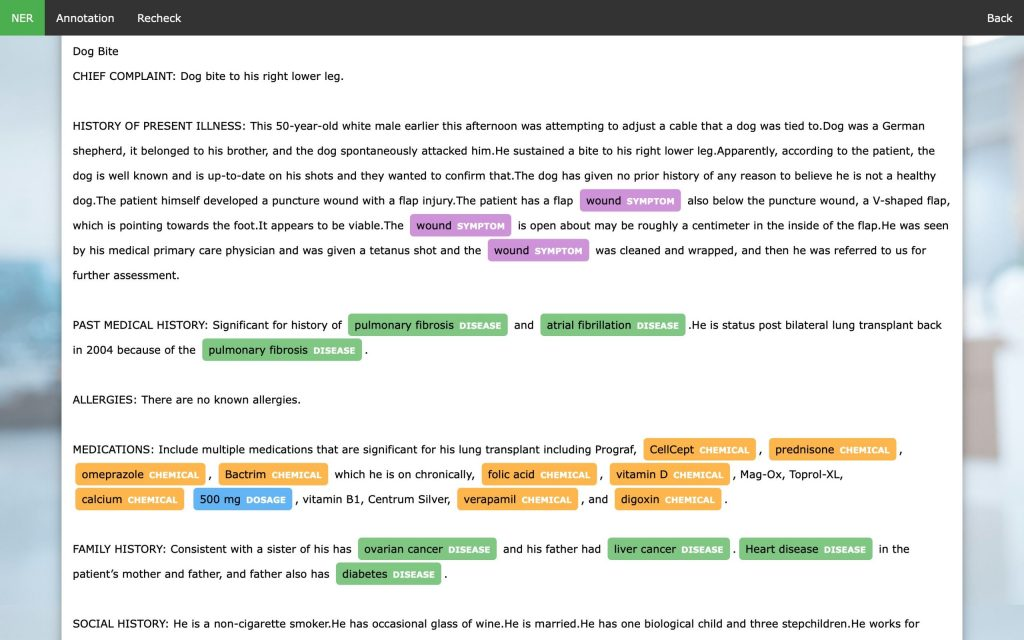

In [3]:
Image(filename = "img/ner_healthcare.jpg", width=800, height=400)

Image courtesy of [Analytics Vidhya](https://editor.analyticsvidhya.com/uploads/77753NER%20healthcare.jpg)

Extracting such elements from documents can help with many downstream tasks, for example
- knowledge discovery (ex. common symptoms for patients diagnosed with COVID)
- adverse drug reactions
- explainability of deep learning models (for highlighted word features of text, are any of them identifiable diseases?)

Large language models (LLMs) are deep learning networks pre-trained pretrained on a corpus of text. The most popular one over the last few years is BERT which was trained on 3.3B tokens.  These models presumably learn basic English semantics that can be used on downstream tasks like NER. So even if you have a small dataset of only a couple hundred examples, you can take advantage of what was learned by an LLM and just fine-tune on the smaller dataset. 

In this project, we use LLMs further trained on biomedical text like clinical notes, which presumably will help us with NER on these types of documents.

# Exploratory Data Analysis

Medical NER is a well-studied task though unfortunately not many public datasets exist.  Here we use datasets provided by [n2c2](https://portal.dbmi.hms.harvard.edu/projects/n2c2-nlp/) (National NLP Clinical Challenges) which has provided NER-related datasets since 2006.  These datasets are provided for competitors in annual clinical NLP challenges sponsored by the NIH.

n2c2 is the current name of the organization hosting these challenges.  It used to be called i2b2, or Integrating Biology and the Bedside.

We will use two datasets.  The first is from the i2b2 2010 challenge [1], in which one of the tasks is medical concept extraction from shortened patient discharge summaries.  The second is from the i2b2 2012 challenge [2], which was to extract temporal information from the same kind of notes, but also provides clinical concepts annotations.

The most common format for NER datasets is the IOB format as shown below.  Every entity in a document is labeled with either a **B**-*ENTITY_TYPE*, to indicate the beginning of an entity, or **I**-*ENTITY_TYPE*, to indicate the middle or end of a named entity.  Although not shown in the image below, any word that is not part of a named entity is labeled with **O**.

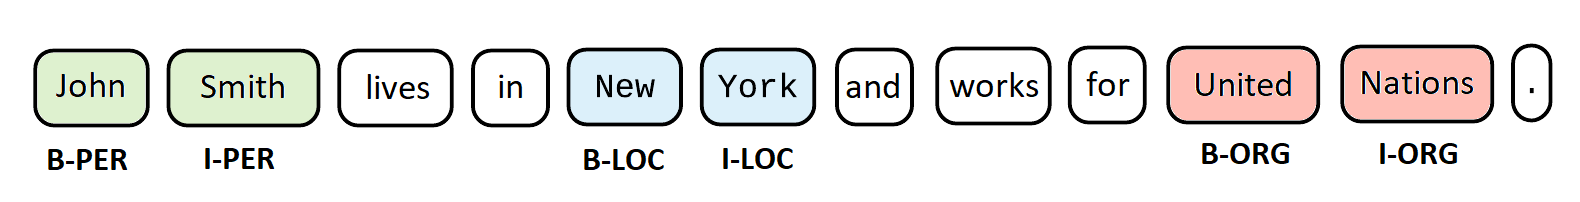

In [4]:
Image(filename = "img/iob_format.png", width=800, height=400)

Image courtesy of [Steve Zheung](https://stevezheng23.github.io/sequence_labeling_tf/ner.iob.example.png)

## i2b2 2010

The i2b2 2010 dataset is a small dataset of 426 discharge summaries that have been annotated with problems, tests and treatments. 

Here's what a typical discharge summary looks like (truncated to 50 lines).

In [5]:
with open('data/i2b2/2010/concept_assertion_relation_training_data/beth/txt/record-21.txt') as f:
    sample_ds = ''.join([l for l in f][:50])

In [6]:
print(sample_ds)

01909607
Admission Date :
2010-06-28
Discharge Date :
2010-07-01
Date of Birth :
1990-02-01
Sex :
F
Service :
ORTHOPEDIC
HISTORY OF THE PRESENT ILLNESS :
This is a 20-year-old female with no significant past medical history , who was the unrestrained passenger in a high speed rollover motor vehicle accident on 2010-06-27 .
By report , the patient was ejected from the vehicle on impact and found curled in the fetal position at the rear of the vehicle at the scene .
The vehicle was noted to be extensively damaged .
By report , the patient was noted to be awake , but confused at the scene of the accident with no memory of the incident .
She was immobilized in the C-spine collar at the scene of the accident and subsequently transported by EMS to the New England Sinai Hospital & Rehab Center Emergency Department for further management .
PHYSICAL EXAMINATION :
Examination on presentation to the emergency room revealed the following :
Temperature 35.4 Celsius , blood pressure 116/63 , pulse 1

The NER labels are specified in a separate document.

In [7]:
with open('data/i2b2/2010/concept_assertion_relation_training_data/beth/concept/record-21.con') as f:
    sample_ds_ann = ''.join([l for l in f][:20])

In [8]:
print(sample_ds_ann)

c="left transverse mid shaft radial fracture" 90:1 90:6||t="problem"
c="ulnar displacement" 90:8 90:9||t="problem"
c="ap and lateral compression" 33:7 33:10||t="test"
c="bun" 55:27 55:27||t="test"
c="erythema" 79:22 79:22||t="problem"
c="apparent distress" 21:10 21:11||t="problem"
c="a 5 cm laceration" 34:0 34:3||t="problem"
c="further inspection" 34:12 34:13||t="test"
c="exposed underlying bone" 34:16 34:18||t="problem"
c="a left upper extremity splint" 80:13 80:17||t="treatment"
c="her c-spine collar" 65:11 65:13||t="treatment"
c="a left radial fracture open reduction" 66:18 66:23||t="treatment"
c="erythema" 72:3 72:3||t="problem"
c="left upper extremity examination" 36:0 36:3||t="test"
c="decreased sensation in the ulnar-nerve distribution" 36:44 36:49||t="problem"
c="gross deformities" 36:6 36:7||t="problem"
c="tenderness" 36:9 36:9||t="problem"
c="right thigh hematoma" 61:29 61:31||t="problem"
c="a duplex evaluation of the right lower extremity" 63:8 63:15||t="test"
c="major arter

Obviously, the documents and annotations are not in IOB format.  There is a separate notebook i2b2_2010_iob.ipynb that converts the original format (separate text and label files) to IOB.  Here we just load the resulting IOB-formatted dataset.

In [9]:
i2b2_2010_dataset_df = pd.read_pickle('data/i2b2/2010/i2b2_dataset_df.pkl')

In [10]:
i2b2_2010_dataset_df.head(20)

,docid,word,NER_tag
0,405507617,405507617,O
1,405507617,FIH,O
2,405507617,2887168,O
3,405507617,132052,O
4,405507617,543394,O
5,405507617,11/12/2002,O
6,405507617,12:00:00,O
7,405507617,AM,O
8,405507617,Discharge,O
9,405507617,Summary,O


There are 3 columns containing the original document id, a word in that document and the NER(IOB) tag for that word.  They are all string objects.

In [11]:
print("Columns with missing data:\n", i2b2_2010_dataset_df.isna().any())

Columns with missing data:
 docid      False
word       False
NER_tag    False
dtype: bool


No columns are missing any data by design.  There were tokens that did not have a label, so we set their label to 'O' in the i2b2_2010_iob.ipynb notebook.

However, there are some docs with BOMs (byte order marks) in them. Remove the BOMs (there are 10 of them, all prepended to the token 'Admission').

In [12]:
i2b2_2010_dataset_df[i2b2_2010_dataset_df['word'].str.contains('\ufeff')]

,docid,word,NER_tag
153746,0001,﻿Admission,O
171875,0005,﻿Admission,O
204359,0401,﻿Admission,O
215872,0333,﻿Admission,O
236369,0009,﻿Admission,O
240133,0377,﻿Admission,O
253071,0439,﻿Admission,O
368300,0373,﻿Admission,O
380507,0349,﻿Admission,O
405555,0421,﻿Admission,O


In [13]:
i2b2_2010_dataset_df['word'] = i2b2_2010_dataset_df.word.apply(lambda x: x.replace('\ufeff', ''))

In [14]:
len(i2b2_2010_dataset_df[i2b2_2010_dataset_df['word'].str.contains('\ufeff')])

0

In [15]:
n_docs = i2b2_2010_dataset_df.docid.nunique()
n_words = i2b2_2010_dataset_df.word.count()

We have 426 documents total in this dataset corresponding to almost 417K tokens, on average 978 tokens per document.

In [16]:
n_docs, n_words, int(np.round(n_words/n_docs))

(426, 416789, 978)

What are the entities and their corresponding frequencies?

In [17]:
def get_tags(df):
    freqs = df.NER_tag.value_counts()
    tags = {}
    for tag, count in zip(freqs.index, freqs):
        if tag != "O":
            if tag[2:] not in tags.keys():
                tags[tag[2:]] = count
            else:
                tags[tag[2:]] += count
        continue
    return tags

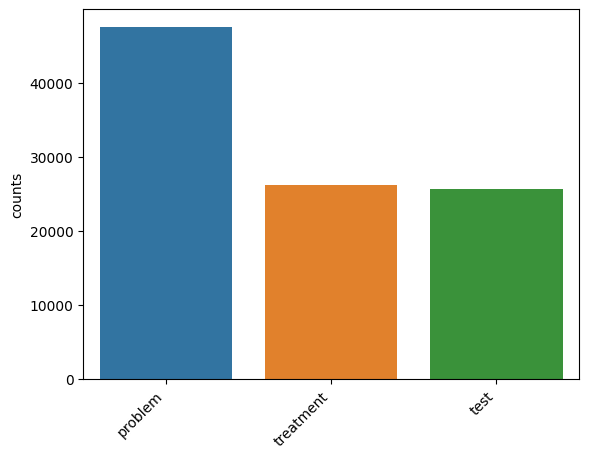

In [18]:
tag_counts = get_tags(i2b2_2010_dataset_df)
tags, counts = zip(*sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))
tag_df = pd.DataFrame({'entity type': tags, 'counts': counts})
chart = sns.barplot(data=tag_df, x="entity type", y="counts")
chart.set(xlabel=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

We have problems, treatments and tests.  The first is not quite double the other labels.

In [19]:
print(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

[('problem', 47599), ('treatment', 26241), ('test', 25726)]


What are the tag frequencies?

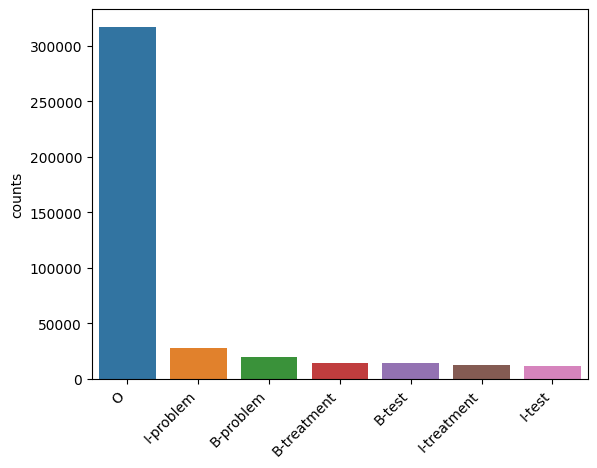

In [20]:
frequencies = i2b2_2010_dataset_df.NER_tag.value_counts()
tag_freq_df = pd.DataFrame({'tag': list(frequencies.index), 'counts': list(frequencies.values)})
chart = sns.barplot(data=tag_freq_df, x="tag", y="counts")
chart.set(xlabel=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

The number of tokens that are not part of a named entity dwarfs the others.  This is unsurprising as most words in a document are not labeled as NERs.

Deep learning models don't handle text labels - we need to assign these numeric values.

In [21]:
i2b2_2010_labels_to_ids = {k: v for v, k in enumerate(i2b2_2010_dataset_df.NER_tag.unique())}
i2b2_2010_ids_to_labels = {v: k for v, k in enumerate(i2b2_2010_dataset_df.NER_tag.unique())}
i2b2_2010_labels_to_ids

{'O': 0,
 'B-problem': 1,
 'I-problem': 2,
 'B-test': 3,
 'I-test': 4,
 'B-treatment': 5,
 'I-treatment': 6}

Also, we need to convert the text of each doc and corresponding IOB labels into sequences.  With respect to correlation, of course the tokens in a document are correlated with each other. But we do not need to assume independence in the models below.

In [22]:
i2b2_2010_dataset_df['doc'] = i2b2_2010_dataset_df[['docid','word','NER_tag']].groupby(
    ['docid'])['word'].transform(lambda x: ' '.join(x))
i2b2_2010_dataset_df['word_labels'] = i2b2_2010_dataset_df[['docid','word','NER_tag']].groupby(
    ['docid'])['NER_tag'].transform(lambda x: ','.join(x))
i2b2_2010_dataset_df = i2b2_2010_dataset_df[["docid", "doc",
                                             "word_labels"]].drop_duplicates().reset_index(drop=True)
i2b2_2010_dataset_df.head()

,docid,doc,word_labels
0,405507617,405507617 FIH 2887168 132052 543394 11/12/2002...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
1,879492218_YC,879492218 YC 53470378 3210349 6/26/2004 12:00:...,"O,O,O,O,O,O,O,B-problem,O,O,O,O,O,O,O,O,O,O,O,..."
2,974381789,974381789 PUOMC 0520610 70648 390115 12/25/199...,"O,O,O,O,O,O,O,O,B-problem,I-problem,O,O,O,O,O,..."
3,523704694,523704694 PRGH 67119280 480282 10/23/1999 12:0...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,274230067_EH,274230067 EH 11456974 175762 02/04/1990 12:00:...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."


Confirm that we have 426 documents.

In [23]:
len(i2b2_2010_dataset_df)

426

View a typical document.

In [24]:
print(i2b2_2010_dataset_df[i2b2_2010_dataset_df.docid == '0029'].doc.item())

Admission Date : 2015-09-14 Discharge Date : 2015-09-19 Date of Birth : 2015-09-14 Sex : M Service : NEONATOLOGY HISTORY OF PRESENT ILLNESS : The patient is a 3285 gm infant born at 37 5/7 weeks to a 21 year old G3 P1 now 2 mother with prenatal screens as follows : O positive , antibody negative , hepatitis B surface antigen negative , RPR nonreactive , GBS negative . Unremarkable pregnancy except for minor fullness of the left renal pelvis reported during the week prior to delivery . Past OB history remarkable for postpartum depression . Mother was admitted in labor . Baby was delivered by repeat C-section with rupture of membranes at delivery . Apgars were 8 and 9 . CMED CSRU staff was called about 30 minutes of age for grunting , flaring and retractions and the baby was admitted to the CMED CSRU . PHYSICAL EXAMINATION : Exam was notable for a term infant with flat anterior fontanelle , pink color , normal facies , intact palate , mild retractions , good air entry , no murmurs . Femo

What are the document lengths?

In [25]:
i2b2_2010_dataset_df['doc_len'] = [len(doc.split()) for doc in i2b2_2010_dataset_df.doc]

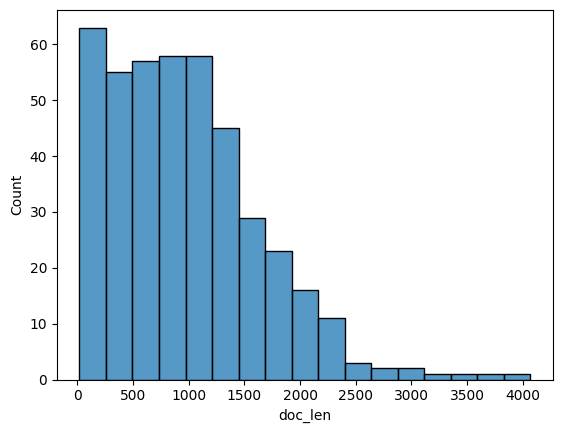

In [26]:
sns.histplot(i2b2_2010_dataset_df['doc_len']);

In [27]:
np.median(i2b2_2010_dataset_df['doc_len']), np.min(i2b2_2010_dataset_df['doc_len']), np.max(i2b2_2010_dataset_df['doc_len'])

(894.0, 20, 4068)

The length of documents is right-skewed.  The average doc has 894 tokens but can be as long as ~4K.  This is important to know because some of the models below, i.e. BERT, are limited to processing 512 tokens.

There is one doc that has only tokens and apparently no labeled entities.  We could get rid of it, but it's unlikely to change our model outcomes and it's likely that sometimes we will get discharge summaries like addendums that don't have much information in them.

In [28]:
print(i2b2_2010_dataset_df[i2b2_2010_dataset_df['doc_len'] == 20].doc.item())
print(i2b2_2010_dataset_df[i2b2_2010_dataset_df['doc_len'] == 20].word_labels.item())

242460787 DH 5950242 67766054 86004855 09/26/2004 12:00:00 AM Face Sheet / Discharge Order SIGNED DIS [ report _ end ]
O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Create a train, dev and test set, with 80% for training and 10% for both dev and testing.

In [29]:
def create_split(df, train_size=0.8):
    train_df = df.sample(frac=train_size, random_state=42)
    rest_df = df.drop(train_df.index).reset_index(drop=True)

    # Split dev and test evenly among the rest
    test_df = rest_df.sample(frac=0.5, random_state=42)
    dev_df = rest_df.drop(test_df.index).reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)

    return train_df, dev_df, test_df

In [30]:
print(f"Full dataset size: {len(i2b2_2010_dataset_df)}")
i2b2_2010_train_df, i2b2_2010_dev_df, i2b2_2010_test_df = create_split(i2b2_2010_dataset_df)

print(f"Train dataset size: {len(i2b2_2010_train_df)}")
print(f"Dev dataset size: {len(i2b2_2010_dev_df)}")
print(f"Test dataset size: {len(i2b2_2010_test_df)}")

Full dataset size: 426
Train dataset size: 341
Dev dataset size: 43
Test dataset size: 42


## i2b2 2012

The i2b2 2012 dataset is a another small dataset consisting of 310 discharge summaries that, like the 2010 dataset, have been annotated with problems, tests, treatments. There are also occurrences, clinical department and evidence labels.

This dataset, too, was not in IOB format, nor was it in the same format as the 2020 data.  The notebook i2b2_2012_iob.ipynb converts it from xml files.  Let's just read in the resulting dataframe.

In [31]:
i2b2_2012_dataset_df = pd.read_pickle('data/i2b2/2012/i2b2_dataset_df.pkl')

In [32]:
i2b2_2012_dataset_df.head(20)

,docid,word,NER_tag
0,18,Admission,B-OCCURRENCE
1,18,Date,O
2,18,:,O
3,18,2016-08-08,O
4,18,Discharge,B-OCCURRENCE
5,18,Date,O
6,18,:,O
7,18,2016-08-15,O
8,18,Discharge,B-OCCURRENCE
9,18,Date,O


This was constructed to have the same format as the 2010 dataset above.  Like that dataset, missing tags were set to 'O' so there are no null values in the columns

In [33]:
print("Columns with missing data:\n", i2b2_2012_dataset_df.isna().any())

Columns with missing data:
 docid      False
word       False
NER_tag    False
dtype: bool


Phew - no BOMs.

In [34]:
len(i2b2_2012_dataset_df[i2b2_2012_dataset_df['word'].str.contains('\ufeff')])

0

In [35]:
n_docs = i2b2_2012_dataset_df.docid.nunique()
n_words = i2b2_2012_dataset_df.word.count()

We have 310 documents total in this dataset corresponding to almost 178K tokens, on average 574 tokens per document.  Clearly these are much shorter documents.

In [36]:
n_docs, n_words, int(np.round(n_words/n_docs))

(310, 178070, 574)

What are the entities and their corresponding frequencies?

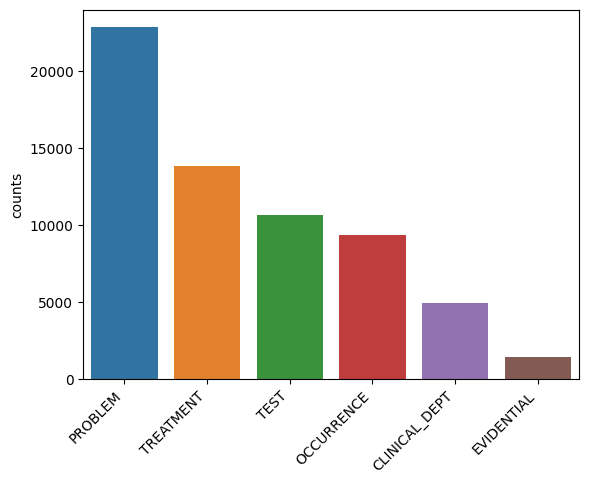

In [37]:
tag_counts = get_tags(i2b2_2012_dataset_df)
tags, counts = zip(*sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))
tag_df = pd.DataFrame({'entity type': tags, 'counts': counts})
chart = sns.barplot(data=tag_df, x="entity type", y="counts")
chart.set(xlabel=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

We have problems, treatments and tests.  Again, we have many more problems than other entity types.  None of them are too few to dismiss.

In [38]:
print(sorted(tag_counts.items(), key=lambda x: x[1], reverse=True))

[('PROBLEM', 22862), ('TREATMENT', 13846), ('TEST', 10693), ('OCCURRENCE', 9364), ('CLINICAL_DEPT', 4977), ('EVIDENTIAL', 1418)]


What are the tag frequencies?

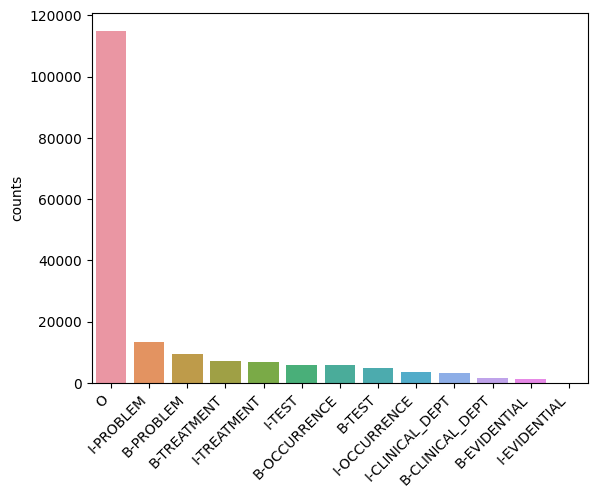

In [39]:
frequencies = i2b2_2012_dataset_df.NER_tag.value_counts()
tag_freq_df = pd.DataFrame({'tag': list(frequencies.index), 'counts': list(frequencies.values)})
chart = sns.barplot(data=tag_freq_df, x="tag", y="counts")
chart.set(xlabel=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

Like the 2010 dataset, athe number of tokens that are not part of a named entity dwarfs the others.

We also need to assign these numeric values.

In [40]:
i2b2_2012_labels_to_ids = {k: v for v, k in enumerate(i2b2_2012_dataset_df.NER_tag.unique())}
i2b2_2012_ids_to_labels = {v: k for v, k in enumerate(i2b2_2012_dataset_df.NER_tag.unique())}
i2b2_2012_labels_to_ids

{'B-OCCURRENCE': 0,
 'O': 1,
 'B-PROBLEM': 2,
 'I-PROBLEM': 3,
 'B-TREATMENT': 4,
 'I-TREATMENT': 5,
 'I-OCCURRENCE': 6,
 'B-EVIDENTIAL': 7,
 'B-TEST': 8,
 'I-TEST': 9,
 'I-EVIDENTIAL': 10,
 'B-CLINICAL_DEPT': 11,
 'I-CLINICAL_DEPT': 12}

Convert the text of each doc and corresponding IOB labels into sequences.

In [41]:
i2b2_2012_dataset_df['doc'] = i2b2_2012_dataset_df[['docid','word','NER_tag']].groupby(['docid'])['word'].transform(lambda x: ' '.join(x))
i2b2_2012_dataset_df['word_labels'] = i2b2_2012_dataset_df[['docid','word','NER_tag']].groupby(['docid'])['NER_tag'].transform(lambda x: ','.join(x))
i2b2_2012_dataset_df = i2b2_2012_dataset_df[["docid", "doc", "word_labels"]].drop_duplicates().reset_index(drop=True)
i2b2_2012_dataset_df.head()

,docid,doc,word_labels
0,18,Admission Date : 2016-08-08 Discharge Date : 2...,"B-OCCURRENCE,O,O,O,B-OCCURRENCE,O,O,O,B-OCCURR..."
1,313,ADMISSION DATE : 06/22/94 DISCHARGE DATE : 07/...,"B-OCCURRENCE,O,O,O,B-OCCURRENCE,O,O,O,O,O,O,O,..."
2,336,ADMISSION DATE : 11/04/2000 DISCHARGE DATE : 1...,"B-OCCURRENCE,O,O,O,B-OCCURRENCE,O,O,O,O,O,O,O,..."
3,178,Admission Date : 2012-01-20 Discharge Date : 2...,"B-OCCURRENCE,O,O,O,B-OCCURRENCE,O,O,O,O,O,O,O,..."
4,692,Admission Date : 2009-11-10 Discharge Date : 2...,"B-OCCURRENCE,O,O,O,B-OCCURRENCE,O,O,O,O,O,O,O,..."


Confirm that we have 310 documents.

In [42]:
len(i2b2_2012_dataset_df)

310

View a typical document.

In [43]:
print(i2b2_2012_dataset_df[i2b2_2012_dataset_df.docid == '18'].doc.item())

Admission Date : 2016-08-08 Discharge Date : 2016-08-15 Discharge Date : 2016-08-15 HISTORY OF PRESENT ILLNESS : The patient is a 37 year old lady with type 1 diabetes mellitus , who is four months postcadaveric kidney transplantation and now has good graft function . She presents for cadaveric pancreas transplantation . Her diabetes mellitus has been complicated by retinopathy and nephropathy as well as peripheral neuropathy . She takes 14 units of NPH insulin twice a day supplementing with a sliding scale . HOSPITAL COURSE : She underwent cadaveric pancreas transplantation without complication . She received induction therapy with thymoglobulin intraoperative and postoperatively for five days . She was kept on a similar immunosuppressive regimen as with her kidney transplant . She had excellent pancreas graft function immediately . Her renal function also remained stable in the perioperative period . She was quickly placed on a diet and advanced to regular diet . She was discharged h

What are the document lengths?

In [44]:
i2b2_2012_dataset_df['doc_len'] = [len(doc.split()) for doc in i2b2_2012_dataset_df.doc]

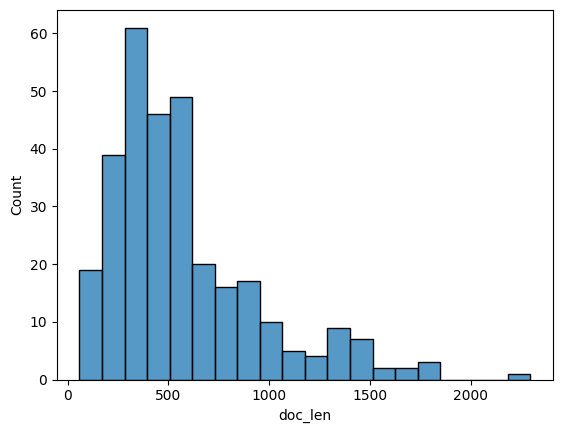

In [45]:
sns.histplot(i2b2_2012_dataset_df['doc_len']);

In [46]:
np.median(i2b2_2012_dataset_df['doc_len']), np.min(i2b2_2012_dataset_df['doc_len']), np.max(i2b2_2012_dataset_df['doc_len'])

(474.0, 59, 2297)

The documents on average are half the size of the ones from 2010.  I'm not sure how realistic this given that discharge summaries are typically much longer docs.   But models like BERT should be able to handle these documents given they are smaller than the 512 token limit.

Create a train, dev and test set, with 80% for training and 10% for both dev and testing.

In [47]:
print(f"Full dataset size: {len(i2b2_2012_dataset_df)}")
i2b2_2012_train_df, i2b2_2012_dev_df, i2b2_2012_test_df = create_split(i2b2_2012_dataset_df)
print(f"Train dataset size: {len(i2b2_2012_train_df)}")
print(f"Dev dataset size: {len(i2b2_2012_dev_df)}")
print(f"Test dataset size: {len(i2b2_2012_test_df)}")

Full dataset size: 310
Train dataset size: 248
Dev dataset size: 31
Test dataset size: 31


# Models

In this section we explore various Pre-trained Large Language Models (PLLMs) to extract named entities from the above datasets. All of these PLLMs are fundamentally based on the Transformer architecture [3], shown below (diagram from paper).

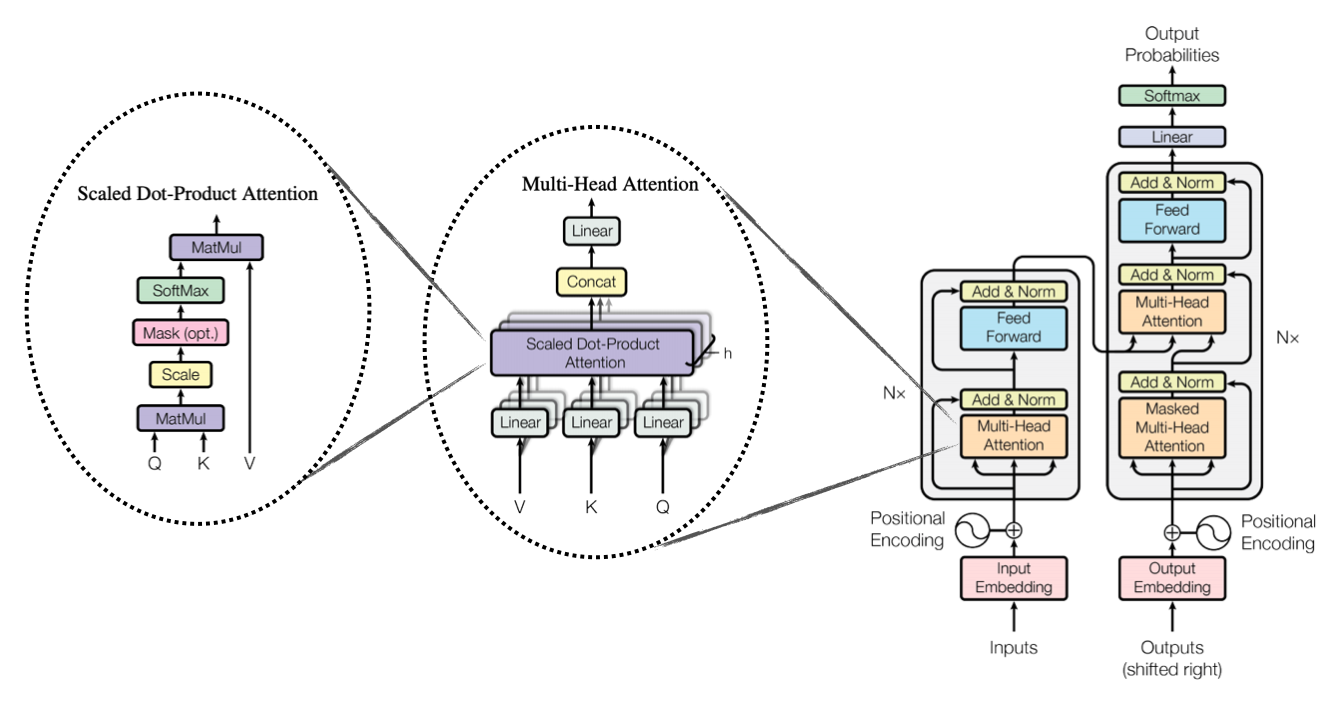

In [47]:
Image(filename = "img/transformer_arch.png", width=800, height=400)

A document is fed as input to the model.  Each token in the document has a contextualized word embedding and positional embedding.  The key element of this architecture is that each token interacts, i.e. pays 'attention' to, every other token.  The resulting computational compexity due to this 'full' attention mechanism, however, is $O(n^2)$.

Also the original version would train by predicting the next word given prior text, i.e. auto-regressive language modeling.  As we go through each model below, we will explain how each one varies from this original model.  The particular models we will cover include the following:

- BERT
- ClinicalBERT
- ClinicalLongformer

All of these will be fine-tuned on each dataset's train split. The IOB tokens will be predicted based on classifiying each token in a sequence as a layer on top of the LLM.

Before we do, however, we need to define a class for feeding the data into these models.  The I2B2Dataset class will take each IOB text and label sequence and convert them to tensor numeric values, truncate them, and pad a batch.

In [48]:
class I2B2Dataset(Dataset):
    """i2b2 IOB-formatted dataset."""
    def __init__(self, df, tokenizer, trunc_len, i2b2_labels_to_ids):
        self.data = df
        self.len = len(self.data)
        self.tokenizer = tokenizer
        self.trunc_len = trunc_len
        self.i2b2_labels_to_ids = i2b2_labels_to_ids

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # Get the document and tag labels
        row = self.data.iloc[idx]
        doc, wordlabels = row.doc.split(), row.word_labels.split(',')

        # Tokenize doc - includes padding and truncation
        encoding = self.tokenizer(doc,
                              is_split_into_words=True,
                              return_offsets_mapping=True,
                              padding='max_length',
                              truncation=True,
                              max_length=self.trunc_len)

        # Create token labels such that only the first part of each word piece is labeled with a tag.
        # The others will be set to -1, which by convention are ignored.
        labels = [self.i2b2_labels_to_ids[label] for label in wordlabels] 
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        i = 0
        for off_idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                # overwrite -1 label
                encoded_labels[off_idx] = labels[i]
                i += 1

        # Convert input_ids, token_type_ids, attention_mask, encoded_labels and offset_mapping
        item = {key: torch.as_tensor(val) for key, val in encoding.items() if key != 'offset_mapping'}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

## Baseline - BERT

The first model we use as a baseline is BERT [4].  BERT uses a masked language model rather than autoregressive language modeling.  Rather than predicting the next word, it randomly masks out tokens and then tries to predict them (image from paper).  It also adds the task of predicting whether 2 sentences are consecutive are not.

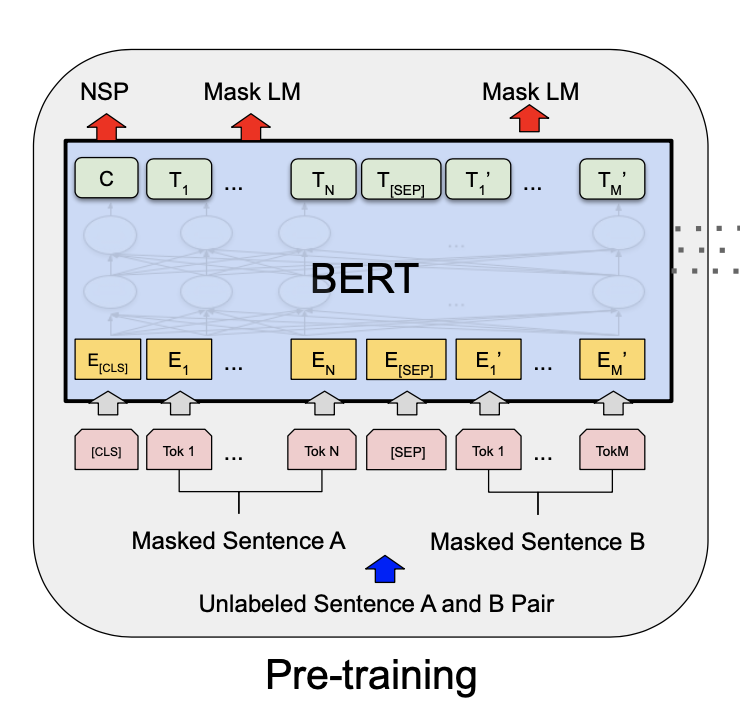

In [47]:
Image(filename = "img/bert_arch.png", width=400, height=200)

We are using this as a baseline as it was trained on a large corpus of over 3B words but the text came from Wikipedia and books, not medical text.

First, we need to get a tokenizer appropriate for BERT and use it to tokenize our datasets.  We start with fine-tuning BERT on the i2b2 2010 dataset.  In processing the dataset, we must truncate sequences to 512 tokens.

In [109]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [57]:
BATCH_SIZE = 8
DEVICE = 'cuda'
MAX_GRAD_NORM = 10

In [120]:
train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

dev_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

In [110]:
i2b2_2010_train_set = I2B2Dataset(i2b2_2010_train_df, tokenizer, 512, i2b2_2010_labels_to_ids)
i2b2_2010_dev_set = I2B2Dataset(i2b2_2010_dev_df, tokenizer, 512, i2b2_2010_labels_to_ids)
i2b2_2010_test_set = I2B2Dataset(i2b2_2010_test_df, tokenizer, 512, i2b2_2010_labels_to_ids)

In [111]:
i2b2_2010_train_loader = DataLoader(i2b2_2010_train_set, **train_params)
i2b2_2010_dev_loader = DataLoader(i2b2_2010_dev_set, **dev_params)
i2b2_2010_test_loader = DataLoader(i2b2_2010_test_set, **dev_params)

Load the BERT pre-trained LLM.

In [52]:
bert_base_model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(i2b2_2010_labels_to_ids))
_ = bert_base_model.to(DEVICE)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We also need to define some functions for the training process.

In [50]:
def train_epoch(epoch, model, training_loader, optimizer, log_wandb=True):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    start_time = time.time()
    for idx, batch in enumerate(training_loader, 0):
        
        ids = batch['input_ids'].to(DEVICE, dtype = torch.long)
        mask = batch['attention_mask'].to(DEVICE, dtype = torch.long)
        labels = batch['labels'].to(DEVICE, dtype = torch.long)

        model_out = model(input_ids=ids, attention_mask=mask, labels=labels)
        loss = model_out.loss
        logits = model_out.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1)
        active_logits = logits.view(-1, model.num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Training took {:.1f} seconds".format(time.time() - start_time))
    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")
    if log_wandb:
        wandb.log({"train loss": epoch_loss, "epoch": epoch})
        wandb.log({"train acc": tr_accuracy, "epoch": epoch})

In [51]:
def validate(model, testing_loader, i2b2_ids_to_labels, epoch=None, log_wandb=True):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(DEVICE, dtype = torch.long)
            mask = batch['attention_mask'].to(DEVICE, dtype = torch.long)
            labels = batch['labels'].to(DEVICE, dtype = torch.long)
            
            model_out = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = model_out.loss
            eval_logits = model_out.logits
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1)
            active_logits = eval_logits.view(-1, model.num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [i2b2_ids_to_labels[id.item()] for id in eval_labels]
    predictions = [i2b2_ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")
    
    if log_wandb:
        wandb.log({"dev loss": eval_loss, "epoch": epoch})
        wandb.log({"dev acc": eval_accuracy, "epoch": epoch})

    return labels, predictions

We're going to conduct a hyperparameter search for the learning rate and number of training epochs that gives us the highest F1 score on the dev set. To help automate this, we will use [Weights and Biases](https://wandb.ai/site) to conduct a hyperparameter sweep.

In [52]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lyol9217 (codegreen). Use `wandb login --relogin` to force relogin


True

In [55]:
sweep_config = {
    'method': 'grid',
    'name': 'sweep',
    'metric': {
        'goal': 'maximize', 
        'name': 'f1'
        },
    'parameters': {
        'epochs': {'values': [10, 20, 30, 40]},
        'lr': {'values': [1e-05, 2e-05, 5e-05]}
     }
}

In [56]:
def train_model(model_fn, train_loader, dev_loader, labels_to_ids, ids_to_labels, config=None):
    """
    Initialize and train a new hyperperameter configuration
    """
    # Initialize a new wandb run
    model = model_fn(labels_to_ids)
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Conatroller
        config = wandb.config

        # Just use Adam as our optimizer
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.lr)
        for epoch in range(config.epochs):
            print(f"Training epoch: {epoch + 1}")
            train_epoch(epoch, model, train_loader, optimizer)
            labels, predictions = validate(model, dev_loader, ids_to_labels, epoch=epoch)
            f1 = f1_score([labels], [predictions])
            wandb.log({"f1": f1, "epoch": epoch})

In [57]:
def baseline_model(labels_to_ids):
    bert_base_model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
    bert_base_model = bert_base_model.to(DEVICE)
    return bert_base_model

In [59]:
train_baseline = partial(train_model, baseline_model, i2b2_2010_train_loader, i2b2_2010_dev_loader,
                         i2b2_2010_labels_to_ids, i2b2_2010_ids_to_labels)

In [60]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-base-2010")

Create sweep with ID: qttroz0p
Sweep URL: https://wandb.ai/codegreen/sweeps-base-2010/sweeps/qttroz0p


Conduct the sweep on the BERT baseline model.

In [ ]:
wandb.agent(sweep_id, train_baseline)

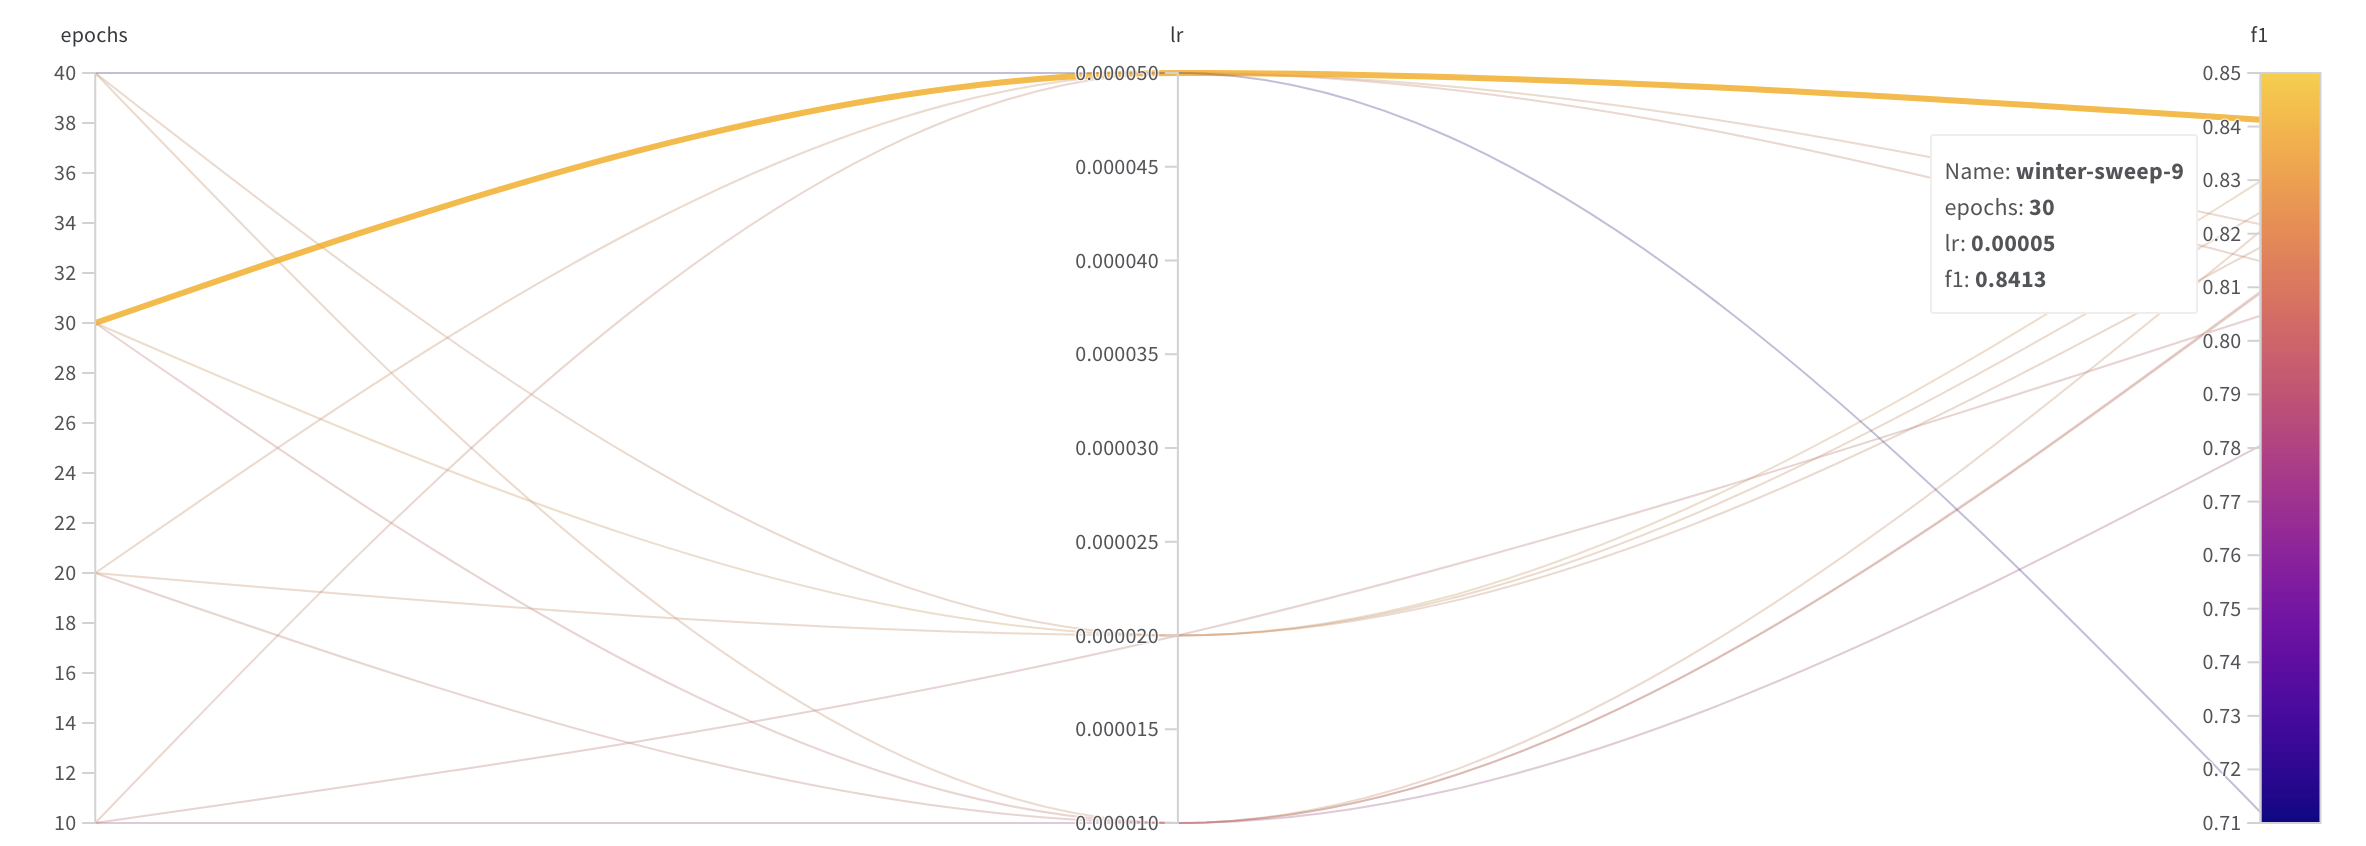

In [62]:
Image(filename = "img/bert_2010_sweep.png", width=1400, height=800)

It looks like we get the best dev F1 when the model is trained for 30 epochs with a learning rate of 0.00005.  Let's retrain to confirm.

In [141]:
bert_base_model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(i2b2_2010_labels_to_ids))
_ = bert_base_model.to(DEVICE)

optimizer = torch.optim.Adam(params=bert_base_model.parameters(), lr=5e-5)
for epoch in range(30):
    print(f"Training epoch: {epoch + 1}")
    train_epoch(epoch, bert_base_model, i2b2_2010_train_loader, optimizer, log_wandb=False)
    labels, predictions = validate(bert_base_model, i2b2_2010_dev_loader, i2b2_2010_ids_to_labels, log_wandb=False)
    f1 = f1_score([labels], [predictions])
    print(f"dev f1 = {f1:.3f}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.044536828994751
Training loss epoch: 0.7513261548308439
Training accuracy epoch: 0.7801697190292812
Validation loss per 100 evaluation steps: 0.32757726311683655
Validation Loss: 0.42053911586602527
Validation Accuracy: 0.8626624860292346
dev f1 = 0.483
Training epoch: 2
Training loss per 100 training steps: 0.5274285674095154
Training loss epoch: 0.289177484637083
Training accuracy epoch: 0.9132236649662278
Validation loss per 100 evaluation steps: 0.13817058503627777
Validation Loss: 0.20073671142260233
Validation Accuracy: 0.9408365839642155
dev f1 = 0.755
Training epoch: 3
Training loss per 100 training steps: 0.44108596444129944
Training loss epoch: 0.16298138419556063
Training accuracy epoch: 0.9540724006398457
Validation loss per 100 evaluation steps: 0.13194063305854797
Validation Loss: 0.18500067541996637
Validation Accuracy: 0.9462662635048961
dev f1 = 0.789
Training epoch: 4
Training loss per 100 training steps: 0.115

In [ ]:
if not os.path.exists('bert_base_model_2010.pth'):
    # Don't accidentally overwrite model
    torch.save(bert_base_model, 'bert_base_model_2010.pth')

This will be the model we run on the test set below in the Results section.

### i2b2 2012

Let's repeat this hyperparameter search training and analysis for the i2b2 2012 dataset.

In [112]:
i2b2_2012_train_set = I2B2Dataset(i2b2_2012_train_df, tokenizer, 512, i2b2_2012_labels_to_ids)
i2b2_2012_dev_set = I2B2Dataset(i2b2_2012_dev_df, tokenizer, 512, i2b2_2012_labels_to_ids)
i2b2_2012_test_set = I2B2Dataset(i2b2_2012_test_df, tokenizer, 512, i2b2_2012_labels_to_ids)

In [113]:
i2b2_2012_train_loader = DataLoader(i2b2_2012_train_set, **train_params)
i2b2_2012_dev_loader = DataLoader(i2b2_2012_dev_set, **dev_params)
i2b2_2012_test_loader = DataLoader(i2b2_2012_test_set, **dev_params)

In [62]:
train_baseline = partial(train_model, baseline_model, i2b2_2012_train_loader, i2b2_2012_dev_loader,
                         i2b2_2012_labels_to_ids, i2b2_2012_ids_to_labels)

In [63]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-base-2012")

Create sweep with ID: fh21d22s
Sweep URL: https://wandb.ai/codegreen/sweeps-base-2012/sweeps/fh21d22s


In [61]:
# Commenting this out for now so we don't see all the log messages in the final notebook.
#wandb.agent(sweep_id, train_baseline)

Again, it looks like we get the best dev F1 when the model is trained for 30 epochs with a learning rate of 0.00005.  Let's retrain to confirm.

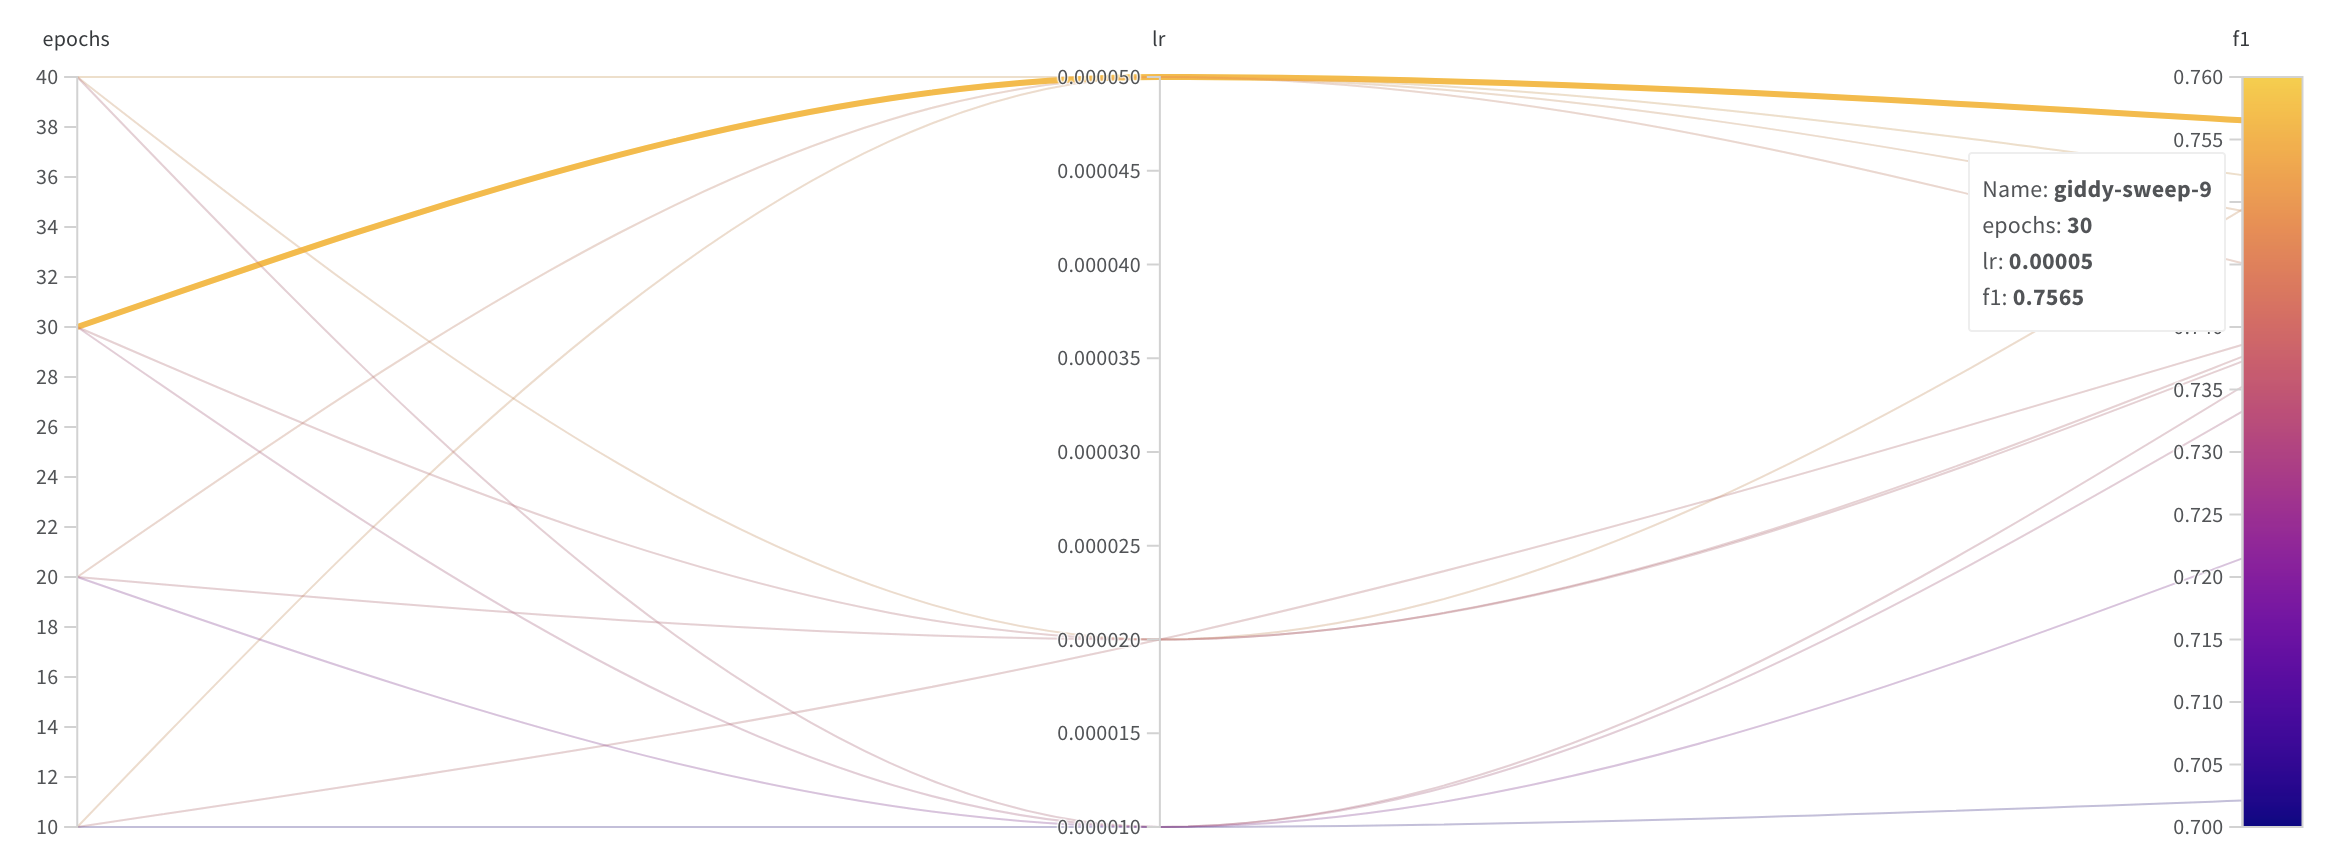

In [66]:
Image(filename = "img/bert_2012_sweep.png", width=1400, height=800)

In [65]:
bert_base_model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(i2b2_2012_labels_to_ids))
_ = bert_base_model.to(DEVICE)

optimizer = torch.optim.Adam(params=bert_base_model.parameters(), lr=5e-5)
for epoch in range(30):
    print(f"Training epoch: {epoch + 1}")
    train_epoch(epoch, bert_base_model, i2b2_2012_train_loader, optimizer, log_wandb=False)
    labels, predictions = validate(bert_base_model, i2b2_2012_dev_loader, i2b2_2012_ids_to_labels, log_wandb=False)
    f1 = f1_score([labels], [predictions])
    print(f"dev f1 = {f1:.3f}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.7157938480377197
Training loss epoch: 1.2359879632149973
Training accuracy epoch: 0.657433613956676
Validation loss per 100 evaluation steps: 0.7728791236877441
Validation Loss: 0.7868065685033798
Validation Accuracy: 0.7633661494956968
dev f1 = 0.409
Training epoch: 2
Training loss per 100 training steps: 0.7513189911842346
Training loss epoch: 0.5698675984336484
Training accuracy epoch: 0.8324692880856481
Validation loss per 100 evaluation steps: 0.4171299338340759
Validation Loss: 0.43355072289705276
Validation Accuracy: 0.8701269488863369
dev f1 = 0.656
Training epoch: 3
Training loss per 100 training steps: 0.36144137382507324
Training loss epoch: 0.33504305443456095
Training accuracy epoch: 0.9004898938388713
Validation loss per 100 evaluation steps: 0.3437809944152832
Validation Loss: 0.365095816552639
Validation Accuracy: 0.8889622648688188
dev f1 = 0.715
Training epoch: 4
Training loss per 100 training steps: 0.28023013

In [68]:
if not os.path.exists('bert_base_model_2012.pth'):
    # Don't accidentally overwrite model
    torch.save(bert_base_model, 'bert_base_model_2012.pth')

## ClinicalBERT

Now we try a model pre-trained on BERT but fine-tuned on clinical notes from the MIMIC-III dataset [6].  ClinicalBERT [5] starts with a BERT baseline and does the same MLM task prediction on ~2M clinical notes including discharge summaries, i.e. documents that are like the i2b2 documents.

Create functions to load the ClinicalBERT pre-trained LLM and data.

In [98]:
def clinical_bert_model(labels_to_ids):
    model = AutoModelForTokenClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(labels_to_ids))
    model = model.to(DEVICE)
    return model

In [63]:
def load_data(model_name, train_df, dev_df, test_df, labels_to_ids, trunc_len, train_params, test_params, is_longformer=False):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, add_prefix_space=is_longformer)
    training_set = I2B2Dataset(train_df, tokenizer, trunc_len, labels_to_ids)
    dev_set = I2B2Dataset(dev_df, tokenizer, trunc_len, labels_to_ids)
    testing_set = I2B2Dataset(test_df, tokenizer, trunc_len, labels_to_ids)

    training_loader = DataLoader(training_set, **train_params)
    dev_loader = DataLoader(dev_set, **train_params)
    testing_loader = DataLoader(testing_set, **test_params)

    return training_loader, dev_loader, testing_loader

In [114]:
cb_i2b2_2010_train_loader, cb_i2b2_2010_dev_loader, cb_i2b2_2010_test_loader = load_data('emilyalsentzer/Bio_ClinicalBERT', 
                                                                                         i2b2_2010_train_df, 
                                                                                         i2b2_2010_dev_df, i2b2_2010_test_df, 
                                                                                         i2b2_2010_labels_to_ids, 
                                                                                         512, train_params, test_params)

In [81]:
train_clinical_bert = partial(train_model, clinical_bert_model, cb_i2b2_2010_train_loader, cb_i2b2_2010_dev_loader,
                              i2b2_2010_labels_to_ids, i2b2_2010_ids_to_labels)

Once again, we do a hyperparameter sweep to find the configuration that gives us the highest average F1 on the dev set. 

In [82]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-cb-2010")

Create sweep with ID: eg8v5ir9
Sweep URL: https://wandb.ai/codegreen/sweeps-cb-2010/sweeps/eg8v5ir9


In [64]:
# Commenting this out for now so we don't see all the log messages in the final notebook.
#wandb.agent(sweep_id, train_clinical_bert)

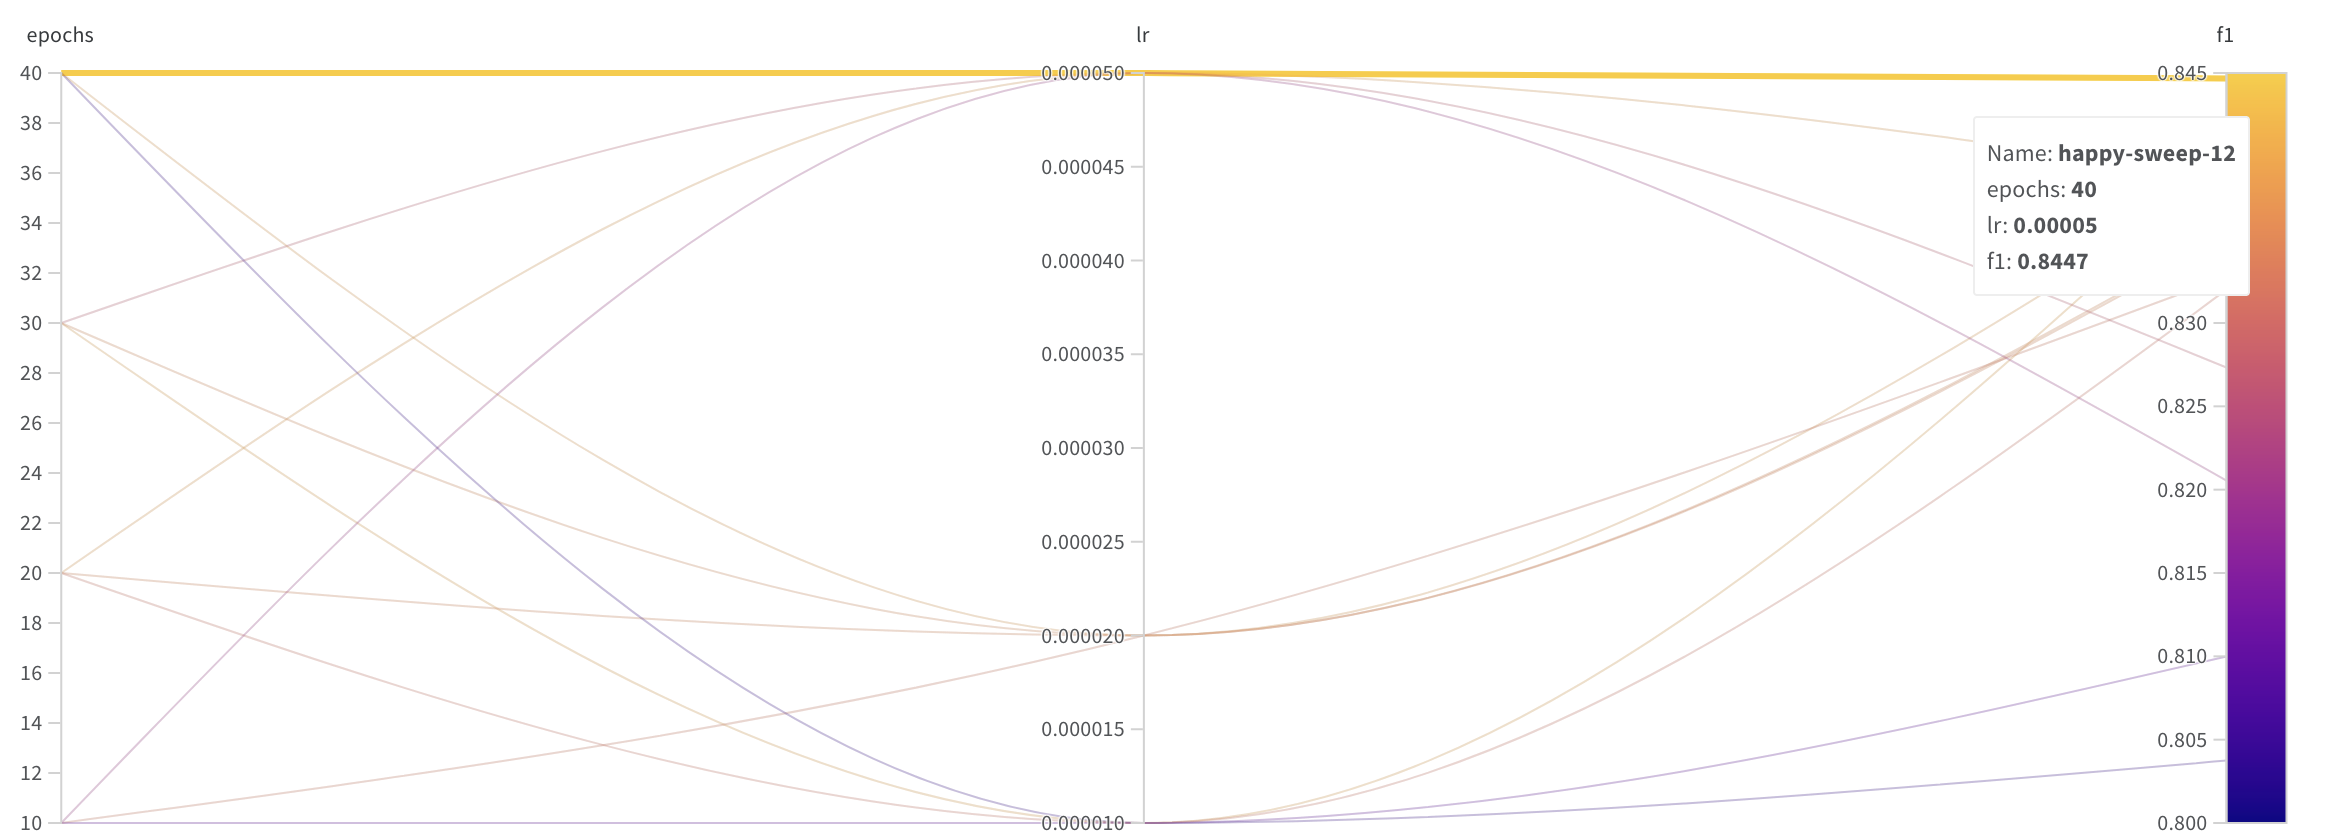

In [86]:
Image(filename = "img/clinical_bert_2010_sweep.png", width=1400, height=800)

It looks like we get the best dev F1 when the model is trained for 40 epochs with a learning rate of 0.00005.  Retrain to confirm.

In [85]:
clinical_bert_model = AutoModelForTokenClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(i2b2_2010_labels_to_ids))
_ = clinical_bert_model.to(DEVICE)

optimizer = torch.optim.Adam(params=clinical_bert_model.parameters(), lr=5e-5)
for epoch in range(40):
    print(f"Training epoch: {epoch + 1}")
    train_epoch(epoch, clinical_bert_model, cb_i2b2_2010_train_loader, optimizer, log_wandb=False)
    labels, predictions = validate(clinical_bert_model, cb_i2b2_2010_dev_loader, i2b2_2010_ids_to_labels, log_wandb=False)
    f1 = f1_score([labels], [predictions])
    print(f"dev f1 = {f1:.3f}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.011596441268921
Training loss epoch: 0.6369037430646808
Training accuracy epoch: 0.8122868027037544
Validation loss per 100 evaluation steps: 0.41881063580513
Validation Loss: 0.2623900721470515
Validation Accuracy: 0.9198560090568432
dev f1 = 0.666
Training epoch: 2
Training loss per 100 training steps: 0.2587689459323883
Training loss epoch: 0.2043660409575285
Training accuracy epoch: 0.939895186442806
Validation loss per 100 evaluation steps: 0.15844866633415222
Validation Loss: 0.16662539541721344
Validation Accuracy: 0.9504986193972308
dev f1 = 0.784
Training epoch: 3
Training loss per 100 training steps: 0.2203509509563446
Training loss epoch: 0.12932399036579353
Training accuracy epoch: 0.963232561251034
Validation loss per 100 evaluation steps: 0.15206287801265717
Validation Loss: 0.15863405664761862
Validation Accuracy: 0.9557108537053174
dev f1 = 0.817
Training epoch: 4
Training loss per 100 training steps: 0.070208631

Unfortunately, it seems we have just got lucky with training for 40 epochs - retrain and just save the model with the best dev f1.

In [91]:
if not os.path.exists('clinical_bert_model_2010.pth'):
    # Don't accidentally overwrite model
    clinical_bert_model = AutoModelForTokenClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(i2b2_2010_labels_to_ids))
    _ = clinical_bert_model.to(DEVICE)
    
    max_f1 = 0.
    epoch_w_best_f1 = -1
    optimizer = torch.optim.Adam(params=clinical_bert_model.parameters(), lr=5e-5)
    for epoch in range(30):
        print(f"Training epoch: {epoch + 1}")
        train_epoch(epoch, clinical_bert_model, cb_i2b2_2010_train_loader, optimizer, log_wandb=False)
        labels, predictions = validate(clinical_bert_model, cb_i2b2_2010_dev_loader, i2b2_2010_ids_to_labels, log_wandb=False)
        f1 = f1_score([labels], [predictions])
        print(f"dev f1 = {f1:.3f}")
        if f1 > max_f1:
            max_f1 = f1
            epoch_w_best_f1 = epoch+1
            torch.save(clinical_bert_model, 'clinical_bert_model_2010.pth')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.267998218536377
Training loss epoch: 0.8014677305554234
Training accuracy epoch: 0.7734196410559453
Validation loss per 100 evaluation steps: 0.5802551507949829
Validation Loss: 0.45327037076155346
Validation Accuracy: 0.8522249476554321
dev f1 = 0.424
Training epoch: 2
Training loss per 100 training steps: 0.48533546924591064
Training loss epoch: 0.30166852439558783
Training accuracy epoch: 0.9097413341136046
Validation loss per 100 evaluation steps: 0.15554176270961761
Validation Loss: 0.18924545248349509
Validation Accuracy: 0.9424317758329478
dev f1 = 0.772
Training epoch: 3
Training loss per 100 training steps: 0.4584932029247284
Training loss epoch: 0.15830701641565145
Training accuracy epoch: 0.9548026318001318
Validation loss per 100 evaluation steps: 0.30931082367897034
Validation Loss: 0.16025676454106966
Validation Accuracy: 0.951889879506779
dev f1 = 0.798
Training epoch: 4
Training loss per 100 training steps: 0.104

In [94]:
print(f"Epoch {epoch_w_best_f1} had the best F1 score at {max_f1:.3f}")

Epoch 17 had the best F1 score at 0.845


### i2b2 2012

At this point, let's do a manual sweep where we train for 40 epochs and try out 2 learning rates that seem to be working well - 0.00001 and 0.0005.  We will save the best performing model based on the dev F1.

In [56]:
cb_i2b2_2012_train_loader, cb_i2b2_2012_dev_loader, cb_i2b2_2012_test_loader = load_data('emilyalsentzer/Bio_ClinicalBERT', 
                                                                                         i2b2_2012_train_df, 
                                                                                         i2b2_2012_dev_df, i2b2_2012_test_df, 
                                                                                         i2b2_2012_labels_to_ids, 
                                                                                         512, train_params, test_params)

In [105]:
if not os.path.exists('clinical_bert_model_2012.pth'):
    max_f1 = 0.
    epoch_w_best_f1 = -1
    best_lr = 0.
    for lr in [1e-5, 5e-5]:
        clinical_bert_model = AutoModelForTokenClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(i2b2_2012_labels_to_ids))
        _ = clinical_bert_model.to(DEVICE)
        optimizer = torch.optim.Adam(params=clinical_bert_model.parameters(), lr=lr)
        for epoch in range(40):
            print(f"Training epoch: {epoch + 1}")
            train_epoch(epoch, clinical_bert_model, cb_i2b2_2012_train_loader, optimizer, log_wandb=False)
            labels, predictions = validate(clinical_bert_model, cb_i2b2_2012_dev_loader, i2b2_2012_ids_to_labels, log_wandb=False)
            f1 = f1_score([labels], [predictions])
            print(f"dev f1 = {f1:.3f}")
            if f1 > max_f1:
                max_f1 = f1
                best_lr = lr
                epoch_w_best_f1 = epoch+1
                torch.save(clinical_bert_model, 'clinical_bert_model_2012.pth')

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.372793674468994
Training loss epoch: 1.1250996551206034
Training accuracy epoch: 0.6871551334546382
Validation loss per 100 evaluation steps: 0.5594222545623779
Validation Loss: 0.601775124669075
Validation Accuracy: 0.8313381538217361
dev f1 = 0.503
Training epoch: 2
Training loss per 100 training steps: 0.6134740710258484
Training loss epoch: 0.4251942028922419
Training accuracy epoch: 0.878646500002996
Validation loss per 100 evaluation steps: 0.2719646692276001
Validation Loss: 0.3397122919559479
Validation Accuracy: 0.8932876801109099
dev f1 = 0.728
Training epoch: 3
Training loss per 100 training steps: 0.3401247262954712
Training loss epoch: 0.2644288088044813
Training accuracy epoch: 0.9186393256266469
Validation loss per 100 evaluation steps: 0.2988085150718689
Validation Loss: 0.31136368960142136
Validation Accuracy: 0.90490118567947
dev f1 = 0.757
Training epoch: 4
Training loss per 100 training steps: 0.2555171847343

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.6735332012176514
Training loss epoch: 1.2632135671954001
Training accuracy epoch: 0.6510150417181262
Validation loss per 100 evaluation steps: 0.7795453667640686
Validation Loss: 0.7682972401380539
Validation Accuracy: 0.7780228465714615
dev f1 = 0.406
Training epoch: 2
Training loss per 100 training steps: 0.8411182165145874
Training loss epoch: 0.5064580546271417
Training accuracy epoch: 0.8586702562113249
Validation loss per 100 evaluation steps: 0.33603808283805847
Validation Loss: 0.3584296777844429
Validation Accuracy: 0.8940377607235762
dev f1 = 0.724
Training epoch: 3
Training loss per 100 training steps: 0.2505406141281128
Training loss epoch: 0.2839672796187862
Training accuracy epoch: 0.9134187696699878
Validation loss per 100 evaluation steps: 0.2600306272506714
Validation Loss: 0.31462185084819794
Validation Accuracy: 0.9016979716304431
dev f1 = 0.746
Training epoch: 4
Training loss per 100 training steps: 0.2491989

In [106]:
print(f"Epoch {epoch_w_best_f1} with lr = {best_lr} had the best F1 score at {max_f1:.3f}")

Epoch 35 with lr = 5e-05 had the best F1 score at 0.784


## ClinicalLongformer

Both BERT and ClinicalBERT share the same architecture, as well as the same limitation of handling up to 512 tokens.  As we saw in the EDA section, the documents in our datasets are on average longer than this.

The fundamental limitation of BERT is that the attention mechanism is applied between each and every token pair.  The Longformer [7] architecture reduces the number of computations by altering the attention.  Attention is now limited to *sparse* attention, in particular 3 kinds:
- local attention: only apply attention between a token and nearby tokens within a window
- dilated attention: apply attention between a token and those a certain distance away
- global attention: a limited number of tokens can pay attention to all of the other tokens

The 3 types of attention are shown below (image from paper)

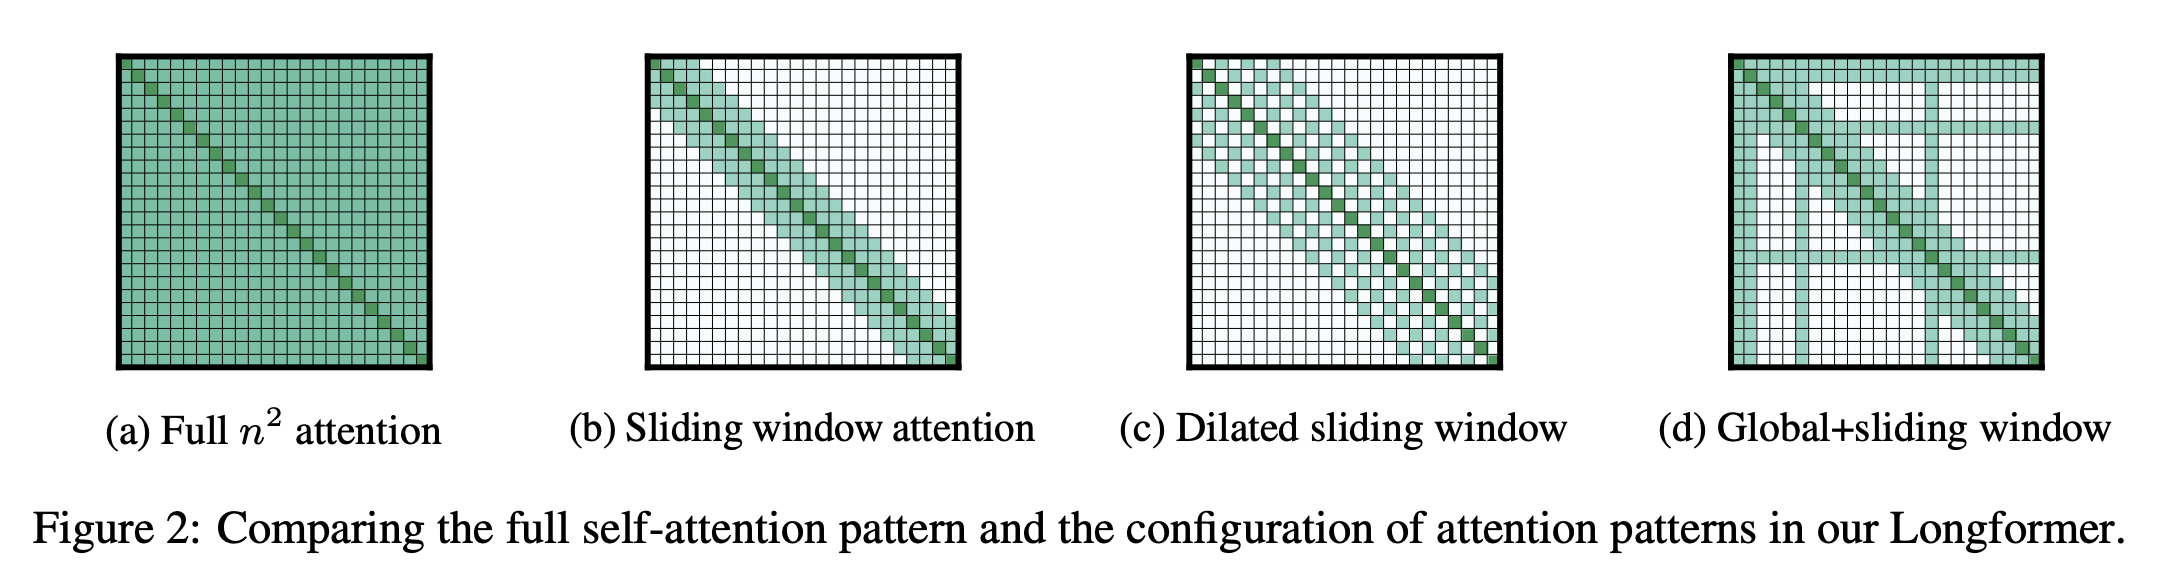

In [108]:
Image(filename = "img/longformer_attn.png", width=800, height=400)

We use a version of Longformer fined-tuned on the MIMIC-III data, ClinicalLongformer [8].

Let's load the data, increasing our trunc size 8 times to 4096.

In [52]:
tokenizer = AutoTokenizer.from_pretrained('yikuan8/Clinical-Longformer', add_prefix_space=True)

In [117]:
training_set = I2B2Dataset(i2b2_2010_train_df, tokenizer, 4096, i2b2_2010_labels_to_ids)
dev_set = I2B2Dataset(i2b2_2010_dev_df, tokenizer, 4096, i2b2_2010_labels_to_ids)
testing_set = I2B2Dataset(i2b2_2010_test_df, tokenizer, 4096, i2b2_2010_labels_to_ids)

cl_i2b2_2010_train_loader = DataLoader(training_set, **train_params)
cl_i2b2_2010_dev_loader = DataLoader(dev_set, **train_params)
cl_i2b2_2010_test_loader = DataLoader(testing_set, **test_params)

With the increase in sequence length, we have to decrease the batch size to get each batch to fit into memory.

In [54]:
train_params = {'batch_size': 4,
                'shuffle': True,
                'num_workers': 0
                }

dev_params = {'batch_size': 4,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': 4,
                'shuffle': False,
                'num_workers': 0
                }

Let's just do a grid search to find the configuration with the best dev F1.

In [61]:
if not os.path.exists('clinical_longformer_model_2010.pth'):
    max_f1 = 0.
    epoch_w_best_f1 = -1
    best_lr = 0.
    for lr in [1e-5, 2e-5, 5e-5]:
        clinical_longformer_model = AutoModelForTokenClassification.from_pretrained('yikuan8/Clinical-Longformer', num_labels=len(i2b2_2010_labels_to_ids))
        _ = clinical_longformer_model.to(DEVICE)
        optimizer = torch.optim.Adam(params=clinical_longformer_model.parameters(), lr=lr)
        for epoch in range(40):
            print(f"Training epoch: {epoch + 1}")
            train_epoch(epoch, clinical_longformer_model, cl_i2b2_2010_train_loader, optimizer, log_wandb=False)
            labels, predictions = validate(clinical_longformer_model, cl_i2b2_2010_dev_loader, i2b2_2010_ids_to_labels, log_wandb=False)
            f1 = f1_score([labels], [predictions])
            print(f"dev f1 = {f1:.3f}")
            if f1 > max_f1:
                max_f1 = f1
                epoch_w_best_f1 = epoch+1
                best_lr = lr
                torch.save(clinical_longformer_model, 'clinical_longformer_model_2010.pth')
                print(f"Epoch {epoch_w_best_f1}, lr={best_lr}, currently has the best F1 score at {max_f1:.3f}")

Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.1597776412963867
Training loss epoch: 0.8268866937520892
Training accuracy epoch: 0.735070779408949
Validation loss per 100 evaluation steps: 0.46616116166114807
Validation Loss: 0.42366574569181964
Validation Accuracy: 0.8667744825106273
dev f1 = 0.517
Epoch 1, lr=1e-05, currently has the best F1 score at 0.517
Training epoch: 2
Training loss per 100 training steps: 0.3620170056819916
Training loss epoch: 0.27659938328487926
Training accuracy epoch: 0.9140709625987651
Validation loss per 100 evaluation steps: 0.1423124372959137
Validation Loss: 0.16346220807595688
Validation Accuracy: 0.9492093640440966
dev f1 = 0.809
Epoch 2, lr=1e-05, currently has the best F1 score at 0.809
Training epoch: 3
Training loss per 100 training steps: 0.16704724729061127
Training loss epoch: 0.15822873559109
Training accuracy epoch: 0.9507723641382434
Validation loss per 100 evaluation steps: 0.10920773446559906
Validation Loss: 0.1262150894511829

Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.0063834190368652
Training loss epoch: 0.5847839756413947
Training accuracy epoch: 0.8246136863879979
Validation loss per 100 evaluation steps: 0.26910194754600525
Validation Loss: 0.19877719743685288
Validation Accuracy: 0.937585653551677
dev f1 = 0.760
Training epoch: 2
Training loss per 100 training steps: 0.24576298892498016
Training loss epoch: 0.16698026925671933
Training accuracy epoch: 0.9471768105313231
Validation loss per 100 evaluation steps: 0.13718821108341217
Validation Loss: 0.12103665213693272
Validation Accuracy: 0.9624209712845923
dev f1 = 0.866
Training epoch: 3
Training loss per 100 training steps: 0.0878538191318512
Training loss epoch: 0.1202650340490563
Training accuracy epoch: 0.9621745570492626
Validation loss per 100 evaluation steps: 0.08782930672168732
Validation Loss: 0.11064678125760773
Validation Accuracy: 0.965774992325813
dev f1 = 0.882
Training epoch: 4
Training loss per 100 training steps: 0.112

Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.137296676635742
Training loss epoch: 0.39367394443861276
Training accuracy epoch: 0.8789995804243522
Validation loss per 100 evaluation steps: 0.11287753283977509
Validation Loss: 0.127728979695927
Validation Accuracy: 0.9601650211000216
dev f1 = 0.860
Training epoch: 2
Training loss per 100 training steps: 0.15007217228412628
Training loss epoch: 0.12289798595444408
Training accuracy epoch: 0.9622032162445059
Validation loss per 100 evaluation steps: 0.09046152979135513
Validation Loss: 0.10688124935735356
Validation Accuracy: 0.9679291037815514
dev f1 = 0.888
Training epoch: 3
Training loss per 100 training steps: 0.06303279101848602
Training loss epoch: 0.09187589304218459
Training accuracy epoch: 0.9711895673141143
Validation loss per 100 evaluation steps: 0.11239689588546753
Validation Loss: 0.10236891223625703
Validation Accuracy: 0.9691934171439474
dev f1 = 0.898
Training epoch: 4
Training loss per 100 training steps: 0.0

In [62]:
print(f"Epoch {epoch_w_best_f1}, lr={best_lr}, currently has the best F1 score at {max_f1:.3f}")

Epoch 30, lr=5e-05, currently has the best F1 score at 0.915


### i2b2 2012

Do the same manual sweep with the i2b2 2012 dataset.

In [55]:
training_set = I2B2Dataset(i2b2_2012_train_df, tokenizer, 4096, i2b2_2012_labels_to_ids)
dev_set = I2B2Dataset(i2b2_2012_dev_df, tokenizer, 4096, i2b2_2012_labels_to_ids)
testing_set = I2B2Dataset(i2b2_2012_test_df, tokenizer, 4096, i2b2_2012_labels_to_ids)

cl_i2b2_2012_train_loader = DataLoader(training_set, **train_params)
cl_i2b2_2012_dev_loader = DataLoader(dev_set, **train_params)
cl_i2b2_2012_test_loader = DataLoader(testing_set, **test_params)

In [58]:
if not os.path.exists('clinical_longformer_model_2012.pth'):
    max_f1 = 0.
    epoch_w_best_f1 = -1
    best_lr = 0.
    for lr in [1e-5, 2e-5, 5e-5]:
        clinical_longformer_model = AutoModelForTokenClassification.from_pretrained('yikuan8/Clinical-Longformer', num_labels=len(i2b2_2012_labels_to_ids))
        _ = clinical_longformer_model.to(DEVICE)
        optimizer = torch.optim.Adam(params=clinical_longformer_model.parameters(), lr=lr)
        for epoch in range(40):
            print(f"Training epoch: {epoch + 1}")
            train_epoch(epoch, clinical_longformer_model, cl_i2b2_2012_train_loader, optimizer, log_wandb=False)
            labels, predictions = validate(clinical_longformer_model, cl_i2b2_2012_dev_loader, i2b2_2012_ids_to_labels, log_wandb=False)
            f1 = f1_score([labels], [predictions])
            print(f"dev f1 = {f1:.3f}")
            if f1 > max_f1:
                max_f1 = f1
                epoch_w_best_f1 = epoch+1
                best_lr = lr
                torch.save(clinical_longformer_model, 'clinical_longformer_model_2012.pth')
                print(f"Epoch {epoch_w_best_f1}, lr={best_lr}, currently has the best F1 score at {max_f1:.3f}")

Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.881614923477173
Training took 96.0 seconds
Training loss epoch: 1.4322091091063716
Training accuracy epoch: 0.6014082200591552
Validation loss per 100 evaluation steps: 0.9177502989768982
Validation Loss: 0.9316605851054192
Validation Accuracy: 0.7167223357037551
dev f1 = 0.292
Epoch 1, lr=1e-05, currently has the best F1 score at 0.292
Training epoch: 2
Training loss per 100 training steps: 0.9405074119567871
Training took 97.0 seconds
Training loss epoch: 0.6610361121354564
Training accuracy epoch: 0.814546861355373
Validation loss per 100 evaluation steps: 0.47132816910743713
Validation Loss: 0.44812116771936417
Validation Accuracy: 0.8686889008924764
dev f1 = 0.643
Epoch 2, lr=1e-05, currently has the best F1 score at 0.643
Training epoch: 3
Training loss per 100 training steps: 0.4075341820716858
Training took 97.3 seconds
Training loss epoch: 0.39280947466050425
Training accuracy epoch: 0.88727572210134
Validation loss per

Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.5683765411376953
Training took 97.5 seconds
Training loss epoch: 1.1077812862011693
Training accuracy epoch: 0.6910611398241266
Validation loss per 100 evaluation steps: 0.5618651509284973
Validation Loss: 0.5282343365252018
Validation Accuracy: 0.8453795630438697
dev f1 = 0.543
Training epoch: 2
Training loss per 100 training steps: 0.5178306698799133
Training took 97.4 seconds
Training loss epoch: 0.401476284188609
Training accuracy epoch: 0.8842061594890398
Validation loss per 100 evaluation steps: 0.37777963280677795
Validation Loss: 0.3297719210386276
Validation Accuracy: 0.8989596669060498
dev f1 = 0.721
Training epoch: 3
Training loss per 100 training steps: 0.3622411787509918
Training took 97.3 seconds
Training loss epoch: 0.28900430904280755
Training accuracy epoch: 0.9124777864116523
Validation loss per 100 evaluation steps: 0.3011442720890045
Validation Loss: 0.30840587615966797
Validation Accuracy: 0.906420978426605


Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training epoch: 1
Training loss per 100 training steps: 2.668637275695801
Training took 97.3 seconds
Training loss epoch: 0.7796667040355744
Training accuracy epoch: 0.7825147945113082
Validation loss per 100 evaluation steps: 0.3612578213214874
Validation Loss: 0.3495079427957535
Validation Accuracy: 0.8934544241557771
dev f1 = 0.709
Training epoch: 2
Training loss per 100 training steps: 0.3318813741207123
Training took 97.5 seconds
Training loss epoch: 0.28844912350177765
Training accuracy epoch: 0.912053593790927
Validation loss per 100 evaluation steps: 0.2683458924293518
Validation Loss: 0.3014177493751049
Validation Accuracy: 0.9069572318970089
dev f1 = 0.759
Training epoch: 3
Training loss per 100 training steps: 0.28091493248939514
Training took 97.4 seconds
Training loss epoch: 0.2258479068836858
Training accuracy epoch: 0.9281256488961193
Validation loss per 100 evaluation steps: 0.341271311044693
Validation Loss: 0.29043146781623363
Validation Accuracy: 0.910560032271423
de

# Results

To recap, we trained a few models for predicting clinical named entities.  For the i2b2 2010 data, these include problems, treatments and tests.  For the i2b2 2012 dataset, these include problems, treatments, tests, occurrences and types of evidence.

For this task, we fine-tuned 3 transformer-based models:
- BERT: a masked language model (MLM) trained on plain English text; limited to handling docs of length less than 512 tokens
- ClinicalBert: a fine-tuning of BERT using EHR documents to incorporate clinical language; also limited to handling docs of length less than 512 tokens
- ClinicalLongformer: a MLM that can handle docs up to 4096 tokens in length by optimizing how attention is done

Our expectation is that ClinicalBERT would perform better than BERT due to incporating clinical terms, and ClinicalLongformer would perform better than ClinicalBERT since it can handle the longer documents like the discharge summaries in both datasets.

Let's run each of the above models on the test dataset for i2b2 2010.

In [118]:
i2b2_2010_results = []
i2b2_2010_model_names = ['bert_base_model_2010', 'clinical_bert_model_2010', 'clinical_longformer_model_2010']
test_dataloaders = [i2b2_2010_test_loader, cb_i2b2_2010_test_loader, cl_i2b2_2010_test_loader]
for modelname, test_dl in tqdm(zip(i2b2_2010_model_names, test_dataloaders)):
    model = torch.load(f'{modelname}.pth')
    labels, predictions = validate(model, test_dl, i2b2_2010_ids_to_labels, log_wandb=False)
    metric_str = classification_report([labels], [predictions])
    i2b2_2010_results.append((modelname, metric_str))

0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.2355547547340393


1it [00:00,  1.26it/s]

Validation Loss: 0.28614854270761664
Validation Accuracy: 0.9535534625102016
Validation loss per 100 evaluation steps: 0.1521887481212616


2it [00:01,  1.30it/s]

Validation Loss: 0.23231115463105115
Validation Accuracy: 0.9597176885842575
Validation loss per 100 evaluation steps: 0.18972235918045044
Validation Loss: 0.22482569786635312
Validation Accuracy: 0.9658101088218941


3it [00:06,  2.02s/it]


In [35]:
for modelname, metric_str in i2b2_2010_results:
    print(f"Model: {modelname}")
    print(metric_str)

Model: bert_base_model_2010
              precision    recall  f1-score   support

     problem       0.84      0.88      0.86       888
        test       0.83      0.84      0.84       390
   treatment       0.79      0.81      0.80       464

   micro avg       0.83      0.85      0.84      1742
   macro avg       0.82      0.85      0.83      1742
weighted avg       0.83      0.85      0.84      1742

Model: clinical_bert_model_2010
              precision    recall  f1-score   support

     problem       0.88      0.87      0.88       833
        test       0.84      0.87      0.85       345
   treatment       0.84      0.87      0.86       440

   micro avg       0.86      0.87      0.87      1618
   macro avg       0.85      0.87      0.86      1618
weighted avg       0.86      0.87      0.87      1618

Model: clinical_longformer_model_2010
              precision    recall  f1-score   support

     problem       0.91      0.90      0.90      2247
        test       0.90      0.

Experimental results on the test dataset show that the F1 score on all entity types does improve when going from the baseline of BERT to ClinicalBert, with a weighted average F1 increase of ~3%.  So it appears that incorporating language from the target domain does indeed help.

The ClinicalLongformer boosts performance even further - a gain of again ~3%.  This is not suprising as it makes sense not to truncate documents by half - the average document length in the dataset was around 1K and we had to truncate to 512 with ClinicalBERT.

Do we see the same pattern with the i2b2 2012 data?

In [108]:
i2b2_2012_results = []
i2b2_2012_model_names = ['bert_base_model_2012', 'clinical_bert_model_2012', 'clinical_longformer_model_2012']
test_dataloaders = [i2b2_2012_test_loader, cb_i2b2_2012_test_loader, cl_i2b2_2012_test_loader]
for modelname, test_dl in tqdm(zip(i2b2_2012_model_names, test_dataloaders)):
    model = torch.load(f'{modelname}.pth').to(DEVICE)
    labels, predictions = validate(model, test_dl, i2b2_2012_ids_to_labels, log_wandb=False)
    metric_str = classification_report([labels], [predictions])
    i2b2_2012_results.append((modelname, metric_str))
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{modelname} has {total_params} parameters")

0it [00:00, ?it/s]

Validation loss per 100 evaluation steps: 0.6295171976089478


1it [00:00,  1.80it/s]

Validation Loss: 0.5536452159285545
Validation Accuracy: 0.9100889272478991
bert_base_model_2012 has 108901645 parameters
Validation loss per 100 evaluation steps: 0.5751218199729919


2it [00:01,  1.88it/s]

Validation Loss: 0.5306838601827621
Validation Accuracy: 0.915083401975302
clinical_bert_model_2012 has 107729677 parameters
Validation loss per 100 evaluation steps: 0.7206337451934814


3it [00:04,  1.36s/it]

Validation Loss: 0.575120359659195
Validation Accuracy: 0.9112083728425328
clinical_longformer_model_2012 has 148078861 parameters


In [88]:
for modelname, metric_str in i2b2_2012_results:
    print(f"Model: {modelname}")
    print(metric_str)

Model: bert_base_model_2012
               precision    recall  f1-score   support

CLINICAL_DEPT       0.83      0.89      0.86       118
   EVIDENTIAL       0.68      0.79      0.73        99
   OCCURRENCE       0.63      0.70      0.66       354
      PROBLEM       0.80      0.87      0.83       656
         TEST       0.79      0.82      0.81       296
    TREATMENT       0.79      0.84      0.81       340

    micro avg       0.76      0.82      0.79      1863
    macro avg       0.75      0.82      0.78      1863
 weighted avg       0.76      0.82      0.79      1863

Model: clinical_bert_model_2012
               precision    recall  f1-score   support

CLINICAL_DEPT       0.90      0.93      0.92       111
   EVIDENTIAL       0.74      0.69      0.71        99
   OCCURRENCE       0.61      0.73      0.67       341
      PROBLEM       0.81      0.86      0.84       643
         TEST       0.82      0.83      0.83       284
    TREATMENT       0.84      0.89      0.86       320



Overall, the scores are not as high, but we do see the same kind of bumps in performace as we did with the i2b2 2010 dataset when going from BERT to ClinicalBERT. The weighted average F1 increases by ~2%. So it appears that incorporating language from the target domain does indeed help in this case as well.

The difference between ClinicalBERT and LongformerBERT does NOT boost performmance.  This is likely because these documents aren't as long as the ones in the 2010 dataset - around 500 tokens vs ~1k.

The big downside with using ClinicalLongformer, or any Longformer model in which the truncate length is longer, is that running time and memory requirements increase because we are able to process more.  We had to halve the batch size for ClinicalLongformer.  On the i2b2 2012 training set, for example, training one epoch on BERT took on average 4.7s vs 96.1s for ClinicalLongformer - an increase of 20 times!!  So unless the discharge summaries are long, ClinicalBERT would be just fine.  In most real-life cases, discharge summaries tend to be on the order of thousands of tokens, so the longer running time of ClinicalLongformer would justify the results.

A final thing to note is that the scores for the i2b2 2010 dataset are on average much higher.  This is not suprising as it has only 3 entity types to predict vs 6 - half as many.  Two of entity types introduced in the 2012 dataset, EVIDENTIAL and OCCURRENCE seem tougher to predict than the others.  Part of the explanation is that they are rarer than some of the others.  Is there something about them that also might make it harder?  Let's look at the most common values for both of these entity types along with PROBLEM, an entity type in which the models did better.

In [99]:
evidential_counter = Counter()
occurrence_counter = Counter()
problem_counter = Counter()
for fn in tqdm(glob.glob('data/i2b2/2012/2012-07-15.original-annotation.release/*.xml')):
    with open(fn) as fp:
        soup = BeautifulSoup(fp, "lxml-xml")
        for i, event in enumerate(soup.find_all('EVENT')):
            text = event.get('text')
            entity_type = event.get('type')
            if entity_type == 'EVIDENTIAL':
                evidential_counter.update([text])
            elif entity_type == 'OCCURRENCE':
                occurrence_counter.update([text])
            elif entity_type == 'PROBLEM':
                problem_counter.update([text])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 202.12it/s]


The most common examples of EVIDENTIAL types strike me as regular verbs.  This would indeed be hard to predict than the nouns of PROBLEM.  Quite frankly, it's not clear the issue with OCCURRENCE. 

In [106]:
table = [['PROBLEM', 'EVIDENTIAL', 'OCCURRENCE']]
for p, e, o in zip(problem_counter.most_common()[:20], evidential_counter.most_common()[:20], occurrence_counter.most_common()[:20]):
    table.append([p[0],e[0],o[0]])
print(tabulate(table))

-----------------------  ------------  ----------------
PROBLEM                  EVIDENTIAL    OCCURRENCE
shortness of breath      showed        transferred
chest pain               revealed      admitted
nausea                   noted         admission
vomiting                 denies        Discharge
afebrile                 reports       Admission
chills                   demonstrated  discharged
pain                     found         discharge
fevers                   complained    stable
hypertension             presented     DISCHARGE
fever                    denied        ADMISSION
unresponsive             states        presented
abdominal pain           reported      well
pneumonia                presents      transfer
hypotension              showing       consulted
atrial fibrillation      stable        improved
diarrhea                 described     tolerated
coronary artery disease  complaints    this admission
complications            Denies        stable condition
COPD    

# Conclusion

We focused on the task of clinical NER For this project, using datasets from the '2010 i2b2/VA Challenge on Concepts, Assertions, and Relations in Clinical Text' and 'Evaluating temporal relations in clinical text: 2012 i2b2 Challenge' competitions.  These were rather small datasets comprised of a couple hundred discharge summaries annotated with clinical concepts like problems, treatments, tests, etc.

To extract these entities, we fine-tuned several Large Language Models (LLMs) including BERT, ClinicalBERT and ClinicalLongformer for prediction.  Incorporating clinical language into an LLM helps on clinical NER, as shown in the improvement of ClinicalBERT over BERT.  Using an LLM that can handle longer sequences like ClinicalLongformer makes a difference when the documents are long.  Otherwise the additional required memory requirements and running time may not be justified.

There are several things to try in the future to try to improve and evaluate the performance for this task:
- Use the cased version of these models
- Identify other types of entities, for example adverse drug events and medications from the [2018 n2c2 shared task](https://academic.oup.com/jamia/article-abstract/27/1/3/5581277?redirectedFrom=fulltext)
- Conduct a deep error analysis including applying various explainability methods to identify the relatively poor performance of OCCURRENCE entities on the 2012 dataset

# References

1. Özlem Uzuner, Brett R South, Shuying Shen, Scott L DuVall, 2010 i2b2/VA challenge on concepts, assertions, and relations in clinical text, Journal of the American Medical Informatics Association, Volume 18, Issue 5, September 2011, Pages 552–556, https://doi.org/10.1136/amiajnl-2011-000203
2. Weiyi Sun, Anna Rumshisky, Ozlem Uzuner, Evaluating temporal relations in clinical text: 2012 i2b2 Challenge, Journal of the American Medical Informatics Association, Volume 20, Issue 5, September 2013, Pages 806–813, https://doi.org/10.1136/amiajnl-2013-001628
3. Vaswani, Ashish et al. “Attention is All you Need.” NIPS (2017).
4. Devlin, Jacob et al. “BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.” North American Chapter of the Association for Computational Linguistics (2019).
5. Emily Alsentzer, John Murphy, William Boag, Wei-Hung Weng, Di Jindi, Tristan Naumann, and Matthew McDermott. 2019. Publicly Available Clinical BERT Embeddings. In Proceedings of the 2nd Clinical Natural Language Processing Workshop, pages 72–78, Minneapolis, Minnesota, USA. Association for Computational Linguistics.
6. Alistair E. W. Johnson, Tom J. Pollard, Lu Shen, Liwei H. Lehman, Mengling Feng, Mohammad Ghassemi, Benjamin Moody, Peter Szolovits, Leo Anthony Celi, and Roger G. Mark. 2016. MIMIC-III, a freely accessible critical care database. Scientific Data, 3:160035.
7. Beltagy, Iz et al. “Longformer: The Long-Document Transformer.” ArXiv abs/2004.05150 (2020)
8. Li, Yikuan et al. “A Comparative Study of Pretrained Language Models for Long Clinical Text.” Journal of the American Medical Informatics Association : JAMIA (2022)